### Imports

In [1]:
import numpy as np
import pandas as pd
import time
import os
import aux_tools as aux
import Tabesh2013functions as tbsh
from collections import defaultdict

### Dataframe

In [2]:
mina_df = pd.read_csv('CP_fases.txt', sep="\s+")
mina_df.rename(columns={'0': 'id'}, inplace=True)

combinaciones = (
    mina_df[['fase', 'z']]
    .drop_duplicates()
    .sort_values(['fase', 'z'], ascending=[True, False])
)

# Asignar número de banco por grupo de fase
combinaciones['banco'] = (
    combinaciones.groupby('fase').cumcount() + 1
)

# Unir esta info de vuelta al df original
mina_df = mina_df.merge(combinaciones, on=['fase', 'z'], how='left')

mina_df.head()

x          y       z        au       cpy      cueq       cus  \
0  491425.0  7456205.0  1968.0  0.288929  1.124707  0.712658  0.022003   
1  491435.0  7456195.0  1968.0  0.266522  1.057851  0.640223  0.021141   
2  491445.0  7456195.0  1968.0  0.243283  2.427782  0.531022  0.019991   
3  491455.0  7456195.0  1968.0  0.243283  2.427782  0.531022  0.019991   
4  491435.0  7456205.0  1968.0  0.288929  1.124707  0.712658  0.022003   

        cut   density  material        py    recg_au    recg_cu     tasox  \
0  0.550661  2.615598         8  0.401511  69.001505  87.011938  0.039957   
1  0.491924  2.626056         8  0.197908  68.839492  87.471598  0.042976   
2  0.396348  2.637350         6  0.399009  68.633711  87.659524  0.050438   
3  0.396348  2.637350         6  0.399009  68.633711  87.659524  0.050438   
4  0.550661  2.615598         8  0.401511  69.001505  87.011938  0.039957   

   tipomineral  fase  id  banco  
0            2     4   1     22  
1            2     4   2     22  
2            2     4   3     22  
3            2     4   4     22  
4            2     4   5     22

### Graficar

Ejemplo de los graficos

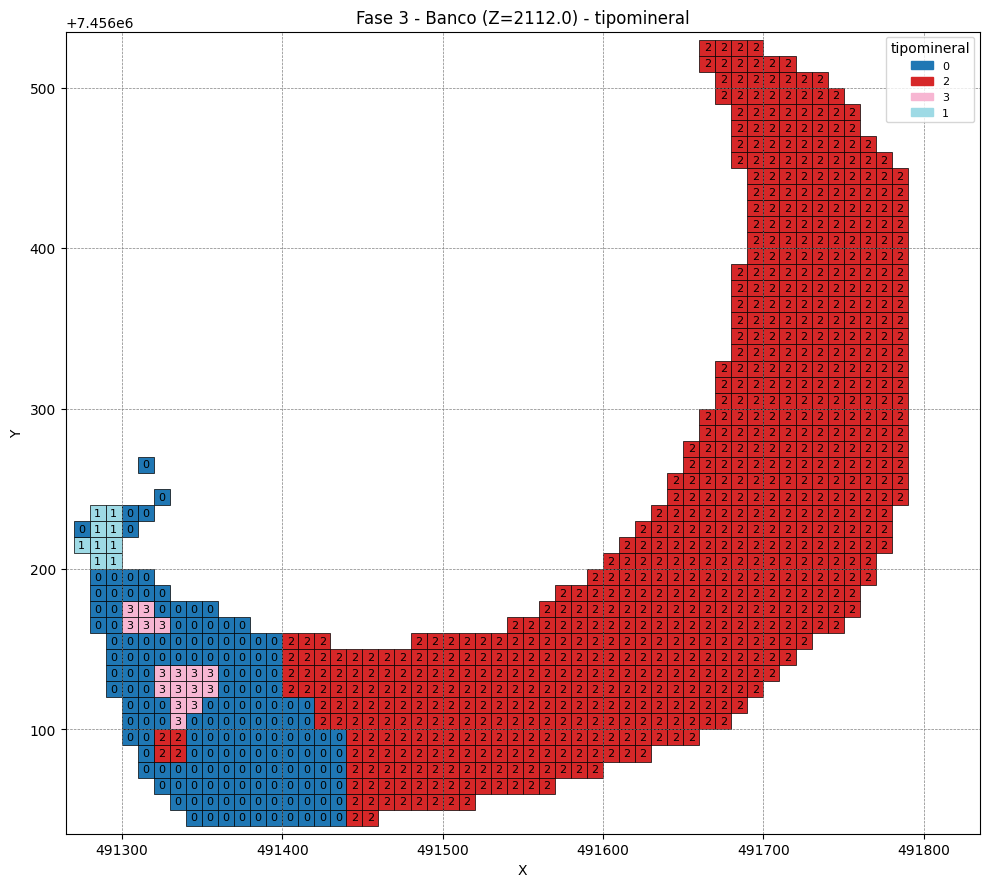

In [4]:
f,b = 3,15
df_filtrado = mina_df[(mina_df['fase']==f)&(mina_df['banco']==b)]
tbsh.plot_fase_banco(df_filtrado, column_hue= 'tipomineral')

Tratando 'tipomineral' como Categórica (4 valores únicos).


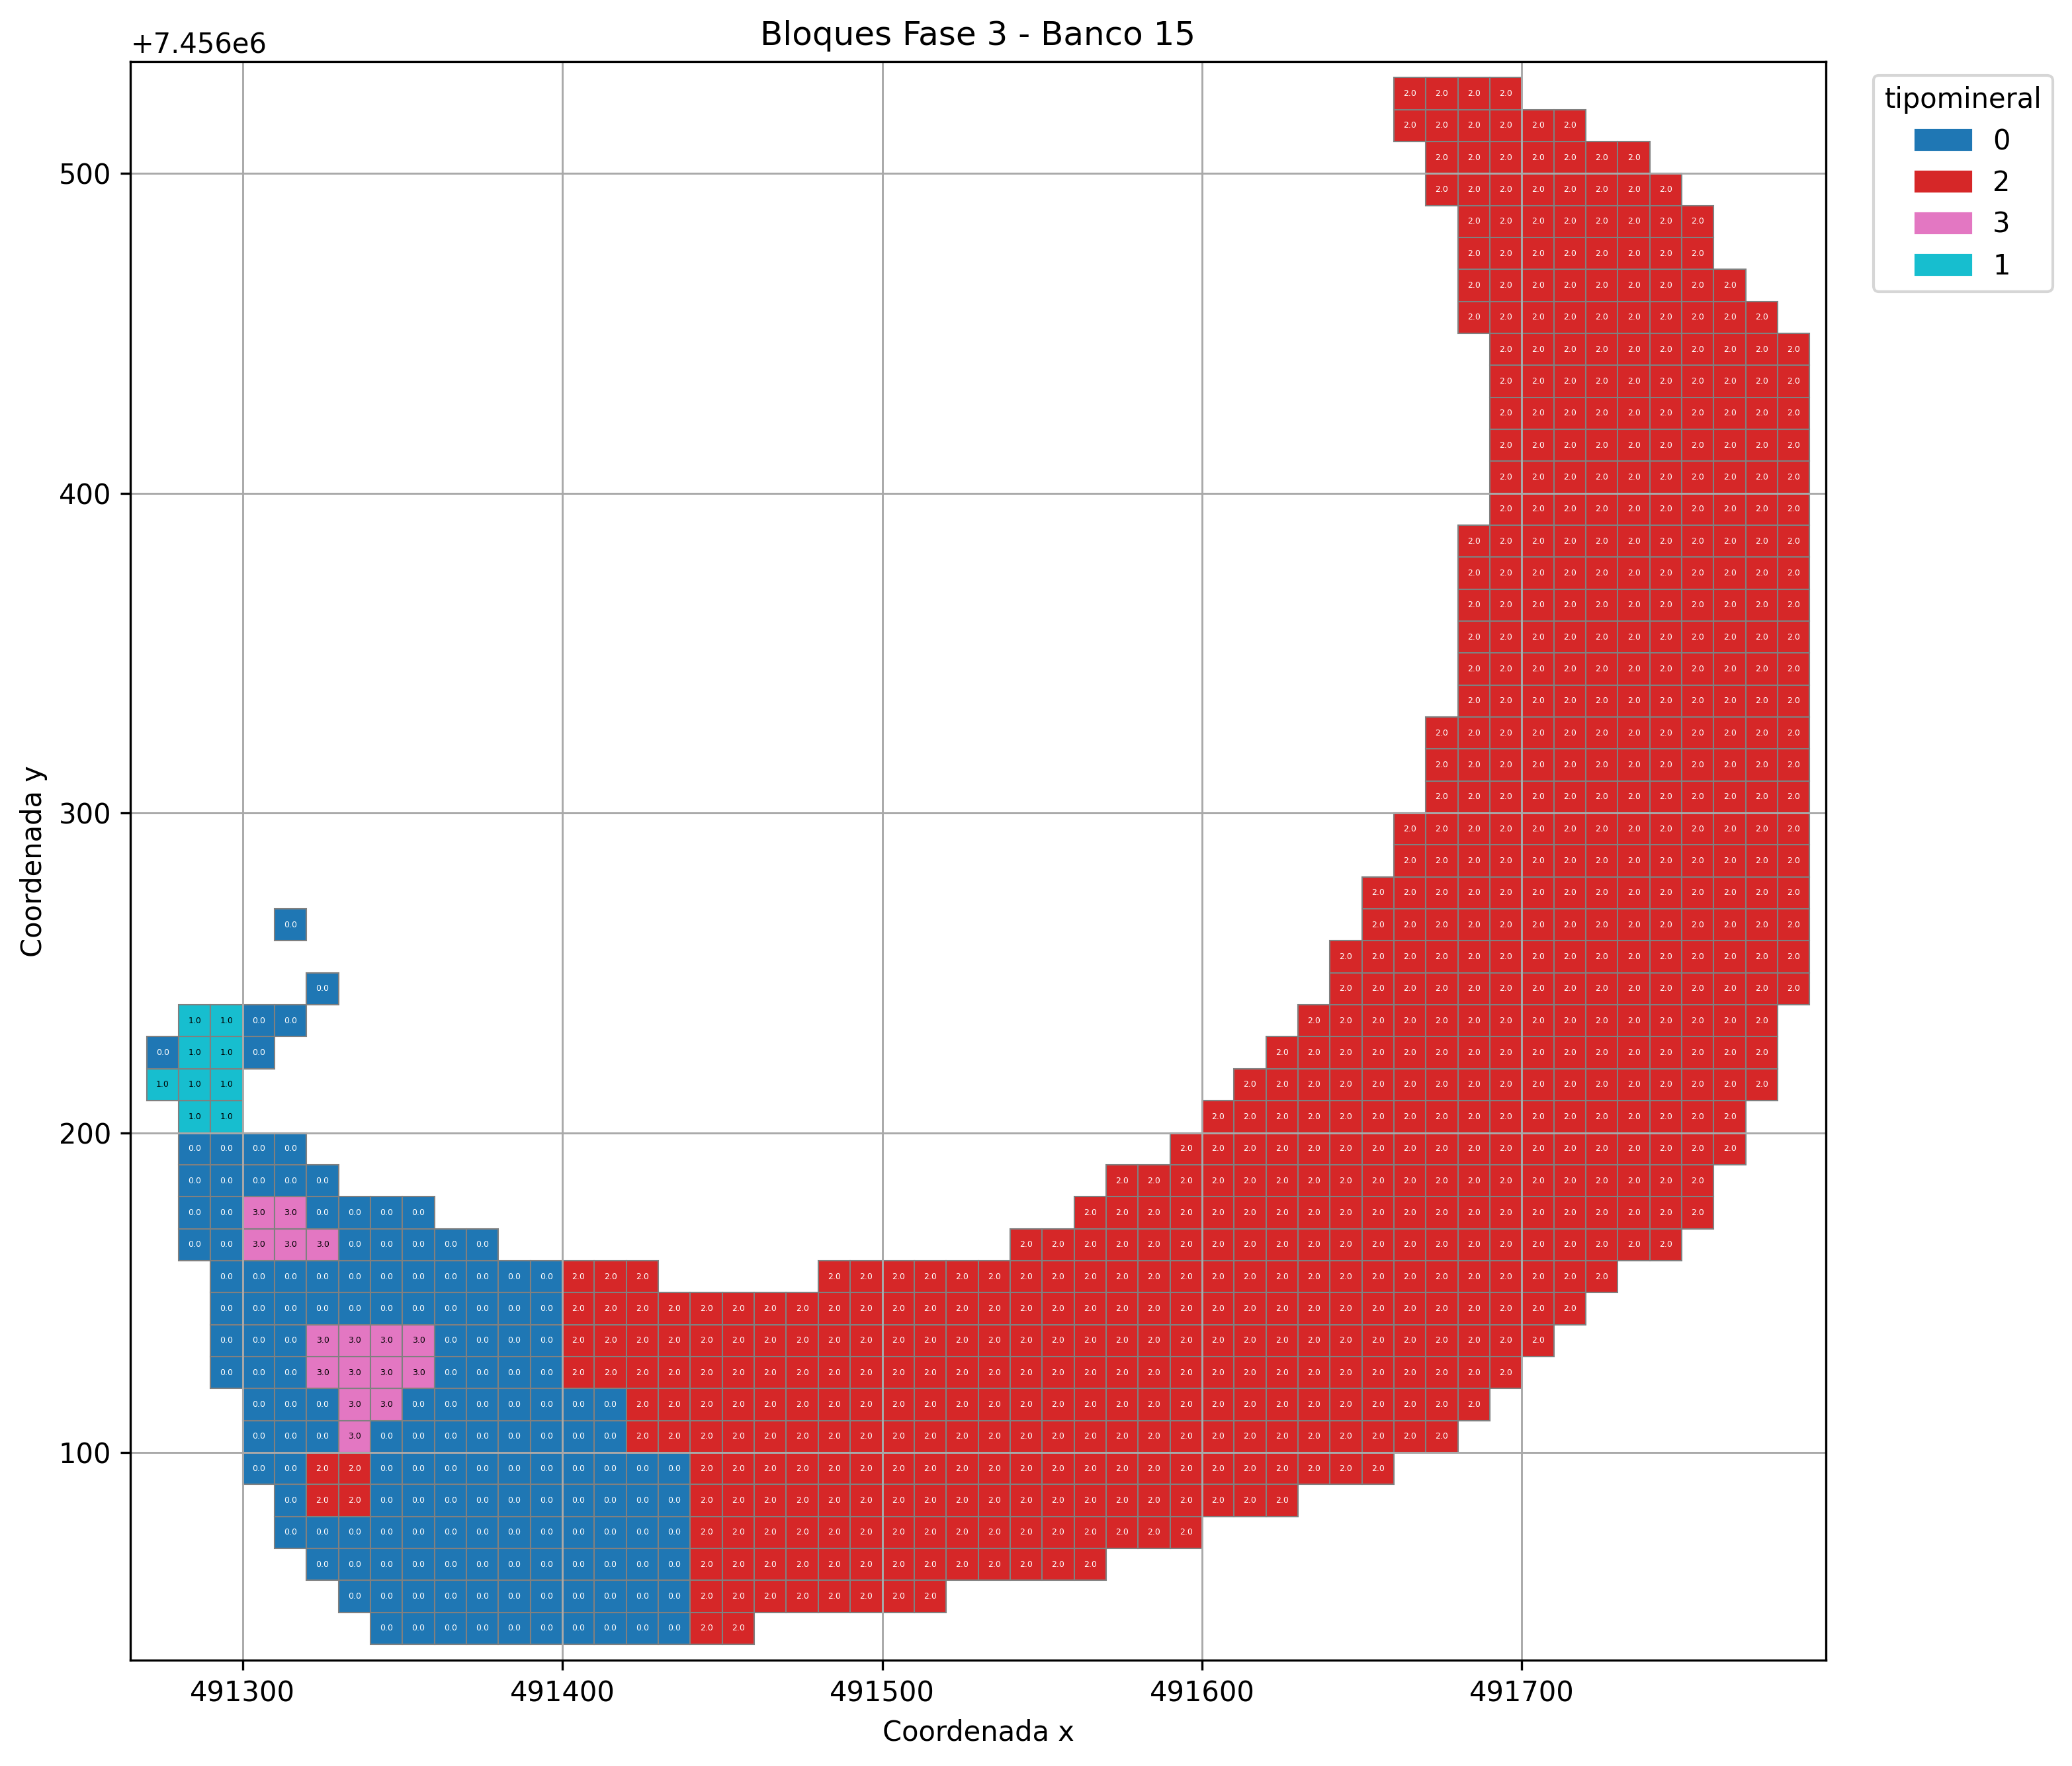

In [9]:
aux.plot_mine_blocks_adv(df_filtrado,
                     color_by_col='tipomineral',
                     title=f"Bloques Fase {f} - Banco {b}",
                     show_block_labels=True, # Mostrar el número de fase
                     fontsize_block_label=3, block_width=10, block_height=10, dpi=300)

Ciclo de Clustering + ShapeRefinement

In [4]:
df = mina_df.copy()
res = aux.Precedencia_Fase_Banco(df)

precedence_tree = defaultdict(list)

for node, predecessor in res:
    precedence_tree[node].append(predecessor)
cleaned_tree = {
    tuple(int(x) for x in k): [tuple(int(y) for y in v_elem) for v_elem in v]
    for k, v in precedence_tree.items()
}
cleaned_tree

{(1, 1): [(1, 2), (2, 2), (3, 4), (4, 2)],
 (1, 2): [(1, 3), (2, 3), (3, 5), (4, 3)],
 (1, 3): [(1, 4), (2, 4), (3, 6), (4, 4)],
 (1, 4): [(1, 5), (2, 5), (3, 7), (4, 5)],
 (1, 5): [(1, 6), (2, 6), (3, 8), (4, 6)],
 (1, 6): [(1, 7), (2, 7), (3, 9), (4, 7)],
 (1, 7): [(1, 8), (2, 8), (3, 10), (4, 8)],
 (1, 8): [(1, 9), (2, 9), (3, 11), (4, 9)],
 (1, 9): [(1, 10), (2, 10), (3, 12), (4, 10)],
 (1, 10): [(1, 11), (2, 11), (3, 13), (4, 11)],
 (1, 11): [(1, 12), (2, 12), (3, 14), (4, 12)],
 (1, 12): [(1, 13), (2, 13), (3, 15), (4, 13)],
 (1, 13): [(1, 14), (2, 14), (3, 16), (4, 14)],
 (1, 14): [(2, 15), (3, 17), (4, 15)],
 (2, 1): [(1, 2), (2, 2), (3, 4), (4, 2)],
 (2, 2): [(1, 3), (2, 3), (3, 5), (4, 3)],
 (2, 3): [(1, 4), (2, 4), (3, 6), (4, 4)],
 (2, 4): [(1, 5), (2, 5), (3, 7), (4, 5)],
 (2, 5): [(1, 6), (2, 6), (3, 8), (4, 6)],
 (2, 6): [(1, 7), (2, 7), (3, 9), (4, 7)],
 (2, 7): [(1, 8), (2, 8), (3, 10), (4, 8)],
 (2, 8): [(1, 9), (2, 9), (3, 11), (4, 9)],
 (2, 9): [(1, 10), (2, 10), (3

In [55]:
df = mina_df.copy()
df['cluster']=-1
df['global_cluster']=''
sorted_unique_z = np.sort(df['z'].unique())
first = True
for Z in sorted_unique_z:
    print(f"---Procesando Z={Z}")
    filtered_df = df[df['z']==Z]
    # Extraes solo las columnas 'fase' y 'banco' y eliminas duplicados
    df_unicos = filtered_df[['fase', 'banco']].drop_duplicates()
    # Lo pasas a lista de tuplas
    tuplas_unicas = list(df_unicos.itertuples(index=False, name=None))
    if first:#Hacemos clustering sin tomar precedencias
        for (f,b) in tuplas_unicas:
            print(f"---Procesando Fase {f} - Banco {b}")
            df_fb = df[(df['fase']==f)&(df['banco']==b)].copy()
            df_fb.reset_index(drop=True, inplace=True)
            A = aux.construir_matriz_adyacencia(df_fb)
            S = aux.Calculate_Similarity_Matrix(df_fb)
            print(f"---Clustering de Fase {f} - Banco {b}")
            current_final_clusters = aux.hierarchical_mine_clustering_adaptado(df_fb,A,S,40,1)
            current_bench_cluster_map = {}
            for cluster_idx, cluster_data in enumerate(current_final_clusters):
                cluster_label = cluster_idx + 1 # Etiqueta 1..K para este banco
                # Crear una etiqueta global única (opcional pero recomendado)
                global_cluster_label = f"F{f}_B{b}_C{cluster_label}"
                for block_id in cluster_data['blocks']:
                    current_bench_cluster_map[block_id] = cluster_label # Mapeo para el siguiente banco
                    # Asignar al DataFrame principal usando la etiqueta global
                    df.loc[df['id'] == block_id, 'cluster'] = cluster_label # Guarda el ID local del banco
                    df.loc[df['id'] == block_id, 'global_cluster'] = global_cluster_label # Guarda etiqueta global
            ### Shape Refinement ###
            print('---Shape Refinement')
            df_fb = df[(df['fase']==f)&(df['banco']==b)].copy()
            df_fb.reset_index(drop=True, inplace=True)
            A = tbsh.Calculate_Adjency_Matrix(df_fb,10)
            data_shape_refinement = tbsh.Shape_Refinement_Tabesh(df_fb, A, Iterations_PostProcessing=20)
            df_fb1 = data_shape_refinement[0]
            # Ahora creamos 'global_cluster' basado en fase f y banco b
            df_fb1['global_cluster'] = df_fb1['cluster'].apply(lambda c: f"F{f}_B{b}_C{c}")

            # Luego actualizas en el df padre
            # Creamos un pequeño dataframe temporal con los valores nuevos
            update_df = df_fb1[['id', 'cluster', 'global_cluster']].copy()

            # Hacemos un merge sobre el df original
            df = df.merge(update_df, on='id', how='left', suffixes=('', '_new'))

            # Ahora actualizamos solamente si hay nueva información
            for col in ['cluster', 'global_cluster']:
                df[col] = df[f'{col}_new'].combine_first(df[col])
                df.drop(columns=[f'{col}_new'], inplace=True)
            #######################
        first=False
    else: #Hay que tomar en cuenta si hay precedencias
        
        for (f,b) in tuplas_unicas:
            print(f"---Procesando Fase {f} - Banco {b}")
            df_fb = df[(df['fase']==f)&(df['banco']==b)].copy()
            df_fb.reset_index(drop=True, inplace=True)
            if (f,b) in cleaned_tree:
                print(f"---Precedencias Detectadas")
                print(cleaned_tree[(f,b)])
                dfs = [] #Guardado de dfs
                for (f_,b_) in cleaned_tree[(f,b)]:
                    dfs.append( (df[(df['fase']==f_)&(df['banco']==b_)]).copy() )
                offset=0
                for df_ in dfs:
                    if not df_.empty:
                        # Ajustamos los clusters
                        df_['cluster'] = df_['cluster'] + offset
                        
                        # Actualizamos el offset: suma el máximo cluster de este df
                        offset = df_['cluster'].max()

                df_inf = pd.concat(dfs, ignore_index=True) #dataframe inferior a f,b
                df_sup = df_fb.copy()
                df_sup.reset_index(drop=True, inplace=True)
                df_sup['cluster'] = df_sup['id']
                A = aux.Calculate_Vertical_Adyacency_Matrix(df_sup,df_inf)
                # Ahora calculamos la matriz C
                c = 0.1
                C = A@A.T
                C = (1-C)*c+C
                S = aux.Calculate_Similarity_Matrix(df_sup)
                #Ahora la similaridad
                S = S*C
                A = aux.construir_matriz_adyacencia(df_sup)
                print(f"---Clustering de Fase {f} - Banco {b}")
                current_final_clusters = aux.hierarchical_mine_clustering_adaptado(df_fb,A,S,40,1)
                current_bench_cluster_map = {}
                for cluster_idx, cluster_data in enumerate(current_final_clusters):
                    cluster_label = cluster_idx + 1 # Etiqueta 1..K para este banco
                    # Crear una etiqueta global única (opcional pero recomendado)
                    global_cluster_label = f"F{f}_B{b}_C{cluster_label}"
                    for block_id in cluster_data['blocks']:
                        current_bench_cluster_map[block_id] = cluster_label # Mapeo para el siguiente banco
                        # Asignar al DataFrame principal usando la etiqueta global
                        df.loc[df['id'] == block_id, 'cluster'] = cluster_label # Guarda el ID local del banco
                        df.loc[df['id'] == block_id, 'global_cluster'] = global_cluster_label # Guarda etiqueta global

                ### Shape Refinement ###
                print('---Shape Refinement')
                df_fb = df[(df['fase']==f)&(df['banco']==b)].copy()
                df_fb.reset_index(drop=True, inplace=True)
                A = tbsh.Calculate_Adjency_Matrix(df_fb,10)
                data_shape_refinement = tbsh.Shape_Refinement_Tabesh(df_fb, A, Iterations_PostProcessing=20)
                df_fb1 = data_shape_refinement[0]
                # Ahora creamos 'global_cluster' basado en fase f y banco b
                df_fb1['global_cluster'] = df_fb1['cluster'].apply(lambda c: f"F{f}_B{b}_C{c}")

                # Luego actualizas en el df padre
                # Creamos un pequeño dataframe temporal con los valores nuevos
                update_df = df_fb1[['id', 'cluster', 'global_cluster']].copy()

                # Hacemos un merge sobre el df original
                df = df.merge(update_df, on='id', how='left', suffixes=('', '_new'))

                # Ahora actualizamos solamente si hay nueva información
                for col in ['cluster', 'global_cluster']:
                    df[col] = df[f'{col}_new'].combine_first(df[col])
                    df.drop(columns=[f'{col}_new'], inplace=True)
                #######################

            else: #(f,b) not in cleaned_tree
                 #CLustering normal
                A = aux.construir_matriz_adyacencia(df_fb)
                S = aux.Calculate_Similarity_Matrix(df_fb)
                print(f"---Clustering de Fase {f} - Banco {b}")
                current_final_clusters = aux.hierarchical_mine_clustering_adaptado(df_fb,A,S,40,1)

                #Asignacion Cluster al df maestro

                current_bench_cluster_map = {}
                for cluster_idx, cluster_data in enumerate(current_final_clusters):
                    cluster_label = cluster_idx + 1 # Etiqueta 1..K para este banco
                    # Crear una etiqueta global única (opcional pero recomendado)
                    global_cluster_label = f"F{f}_B{b}_C{cluster_label}"
                    for block_id in cluster_data['blocks']:
                        current_bench_cluster_map[block_id] = cluster_label # Mapeo para el siguiente banco
                        # Asignar al DataFrame principal usando la etiqueta global
                        df.loc[df['id'] == block_id, 'cluster'] = cluster_label # Guarda el ID local del banco
                        df.loc[df['id'] == block_id, 'global_cluster'] = global_cluster_label # Guarda etiqueta global

                ### Shape Refinement ###
                print('---Shape Refinement')
                df_fb = df[(df['fase']==f)&(df['banco']==b)].copy()
                df_fb.reset_index(drop=True, inplace=True)
                A = tbsh.Calculate_Adjency_Matrix(df_fb,10)
                data_shape_refinement = tbsh.Shape_Refinement_Tabesh(df_fb, A, Iterations_PostProcessing=20)
                df_fb1 = data_shape_refinement[0]
                # Ahora creamos 'global_cluster' basado en fase f y banco b
                df_fb1['global_cluster'] = df_fb1['cluster'].apply(lambda c: f"F{f}_B{b}_C{c}")

                # Luego actualizas en el df padre
                # Creamos un pequeño dataframe temporal con los valores nuevos
                update_df = df_fb1[['id', 'cluster', 'global_cluster']].copy()

                # Hacemos un merge sobre el df original
                df = df.merge(update_df, on='id', how='left', suffixes=('', '_new'))

                # Ahora actualizamos solamente si hay nueva información
                for col in ['cluster', 'global_cluster']:
                    df[col] = df[f'{col}_new'].combine_first(df[col])
                    df.drop(columns=[f'{col}_new'], inplace=True)
                #######################



     

---Procesando Z=1952.0
---Procesando Fase 4 - Banco 23
---Clustering de Fase 4 - Banco 23
---Shape Refinement
========PostProcessing Results========
Total de clusters: 13
Tiempo: 0.16721010208129883
---Procesando Z=1968.0
---Procesando Fase 4 - Banco 22
---Precedencias Detectadas
[(4, 23)]
---Clustering de Fase 4 - Banco 22
---Shape Refinement
========PostProcessing Results========
Total de clusters: 25
Tiempo: 1.353766679763794
---Procesando Z=1984.0
---Procesando Fase 4 - Banco 21
---Precedencias Detectadas
[(4, 22)]
---Clustering de Fase 4 - Banco 21
---Shape Refinement
========PostProcessing Results========
Total de clusters: 32
Tiempo: 1.7656731605529785
---Procesando Fase 3 - Banco 23
---Precedencias Detectadas
[(4, 22)]
---Clustering de Fase 3 - Banco 23
---Shape Refinement
========PostProcessing Results========
Total de clusters: 6
Tiempo: 0.10323381423950195
---Procesando Z=2000.0
---Procesando Fase 4 - Banco 20
---Precedencias Detectadas
[(3, 23), (4, 21)]
---Clustering de Fa

In [56]:
df.to_csv("df_mina_clustered_w_shape_refinement.csv", index=False)

In [57]:
df

x          y       z        au       cpy      cueq       cus  \
0      491425.0  7456205.0  1968.0  0.288929  1.124707  0.712658  0.022003   
1      491435.0  7456195.0  1968.0  0.266522  1.057851  0.640223  0.021141   
2      491445.0  7456195.0  1968.0  0.243283  2.427782  0.531022  0.019991   
3      491455.0  7456195.0  1968.0  0.243283  2.427782  0.531022  0.019991   
4      491435.0  7456205.0  1968.0  0.288929  1.124707  0.712658  0.022003   
...         ...        ...     ...       ...       ...       ...       ...   
91277  491985.0  7456545.0  2320.0  0.010000  0.043324  0.015000  0.001000   
91278  491975.0  7456555.0  2320.0  0.010000  0.043324  0.015000  0.001000   
91279  491985.0  7456555.0  2320.0  0.010000  0.043324  0.015000  0.001000   
91280  491975.0  7456565.0  2320.0  0.017194  0.112734  0.039031  0.006303   
91281  491975.0  7456575.0  2320.0  0.017194  0.112734  0.039031  0.006303   

            cut   density  material        py    recg_au    recg_cu     tasox  \
0      0.550661  2.615598         8  0.401511  69.001505  87.011938  0.039957   
1      0.491924  2.626056         8  0.197908  68.839492  87.471598  0.042976   
2      0.396348  2.637350         6  0.399009  68.633711  87.659524  0.050438   
3      0.396348  2.637350         6  0.399009  68.633711  87.659524  0.050438   
4      0.550661  2.615598         8  0.401511  69.001505  87.011938  0.039957   
...         ...       ...       ...       ...        ...        ...       ...   
91277  0.015000  2.352000         0  0.000000   0.000000   0.000000  0.066667   
91278  0.015000  2.352000         0  0.000000   0.000000   0.000000  0.066667   
91279  0.015000  2.352000         0  0.000000   0.000000   0.000000  0.066667   
91280  0.039031  2.352000         0  0.000000   0.000000   0.000000  0.161474   
91281  0.039031  2.352000         0  0.000000   0.000000   0.000000  0.161474   

       tipomineral  fase     id  banco  cluster global_cluster  
0                2     4      1     22      1.0    F4_B22_C1.0  
1                2     4      2     22      1.0    F4_B22_C1.0  
2                2     4      3     22      1.0    F4_B22_C1.0  
3                2     4      4     22      1.0    F4_B22_C1.0  
4                2     4      5     22      1.0    F4_B22_C1.0  
...            ...   ...    ...    ...      ...            ...  
91277            0     3  91278      2     17.0    F3_B2_C17.0  
91278            0     3  91279      2     17.0    F3_B2_C17.0  
91279            0     3  91280      2     17.0    F3_B2_C17.0  
91280            0     3  91281      2     17.0    F3_B2_C17.0  
91281            0     3  91282      2     17.0    F3_B2_C17.0  

[91282 rows x 20 columns]

In [54]:
df[(df['fase']==4)&(df['banco']==23)]

x          y       z        au       cpy      cueq       cus  \
86    491505.0  7456245.0  1952.0  0.419002  1.048079  0.822225  0.011422   
87    491495.0  7456255.0  1952.0  0.367047  1.089570  0.772908  0.013826   
88    491505.0  7456255.0  1952.0  0.419002  1.048079  0.819099  0.011422   
89    491515.0  7456255.0  1952.0  0.419002  1.048079  0.822225  0.011422   
90    491495.0  7456265.0  1952.0  0.245280  1.013393  0.743408  0.015996   
...        ...        ...     ...       ...       ...       ...       ...   
1073  491475.0  7456525.0  1952.0  0.064586  0.886269  0.394640  0.014745   
1074  491485.0  7456525.0  1952.0  0.065936  0.893564  0.381899  0.011334   
1084  491495.0  7456515.0  1952.0  0.080189  1.039957  0.388811  0.013431   
1085  491505.0  7456515.0  1952.0  0.091157  1.180986  0.441636  0.013528   
1086  491515.0  7456515.0  1952.0  0.091157  1.180986  0.441636  0.013528   

           cut   density  material        py    recg_au    recg_cu     tasox  \
86    0.581412  2.615342         8  0.356467  70.043736  86.166615  0.019645   
87    0.565130  2.618500         8  0.367336  69.634071  86.971880  0.024466   
88    0.581412  2.615342         8  0.356467  70.043736  87.299927  0.019645   
89    0.581412  2.615342         8  0.356467  70.043736  86.166615  0.019645   
90    0.605995  2.600831         8  0.376281  68.673008  86.667413  0.026396   
...        ...       ...       ...       ...        ...        ...       ...   
1073  0.359835  2.604828         5  1.309779  62.060972  81.423946  0.040978   
1074  0.346320  2.653363         5  1.094824  62.388802  81.746966  0.032727   
1084  0.342893  2.650930         5  0.983553  66.271815  81.828216  0.039170   
1085  0.387500  2.637810         6  0.573205  69.197173  82.381361  0.034912   
1086  0.387500  2.637810         6  0.573205  69.197173  82.381361  0.034912   

      tipomineral  fase    id  banco  cluster global_cluster  
86              2     4    87     23      1.0      F4_B23_C1  
87              2     4    88     23      1.0      F4_B23_C1  
88              2     4    89     23      1.0      F4_B23_C1  
89              2     4    90     23      1.0      F4_B23_C1  
90              2     4    91     23      1.0      F4_B23_C1  
...           ...   ...   ...    ...      ...            ...  
1073            2     4  1074     23     12.0     F4_B23_C12  
1074            2     4  1075     23     12.0     F4_B23_C12  
1084            2     4  1085     23     12.0     F4_B23_C12  
1085            2     4  1086     23     13.0     F4_B23_C13  
1086            2     4  1087     23     13.0     F4_B23_C13  

[393 rows x 20 columns]

In [45]:
df_inf

x          y       z        au       cpy      cueq       cus  \
0    491505.0  7456245.0  1952.0  0.419002  1.048079  0.822225  0.011422   
1    491495.0  7456255.0  1952.0  0.367047  1.089570  0.772908  0.013826   
2    491505.0  7456255.0  1952.0  0.419002  1.048079  0.819099  0.011422   
3    491515.0  7456255.0  1952.0  0.419002  1.048079  0.822225  0.011422   
4    491495.0  7456265.0  1952.0  0.245280  1.013393  0.743408  0.015996   
..        ...        ...     ...       ...       ...       ...       ...   
388  491475.0  7456525.0  1952.0  0.064586  0.886269  0.394640  0.014745   
389  491485.0  7456525.0  1952.0  0.065936  0.893564  0.381899  0.011334   
390  491495.0  7456515.0  1952.0  0.080189  1.039957  0.388811  0.013431   
391  491505.0  7456515.0  1952.0  0.091157  1.180986  0.441636  0.013528   
392  491515.0  7456515.0  1952.0  0.091157  1.180986  0.441636  0.013528   

          cut   density  material        py    recg_au    recg_cu     tasox  \
0    0.581412  2.615342         8  0.356467  70.043736  86.166615  0.019645   
1    0.565130  2.618500         8  0.367336  69.634071  86.971880  0.024466   
2    0.581412  2.615342         8  0.356467  70.043736  87.299927  0.019645   
3    0.581412  2.615342         8  0.356467  70.043736  86.166615  0.019645   
4    0.605995  2.600831         8  0.376281  68.673008  86.667413  0.026396   
..        ...       ...       ...       ...        ...        ...       ...   
388  0.359835  2.604828         5  1.309779  62.060972  81.423946  0.040978   
389  0.346320  2.653363         5  1.094824  62.388802  81.746966  0.032727   
390  0.342893  2.650930         5  0.983553  66.271815  81.828216  0.039170   
391  0.387500  2.637810         6  0.573205  69.197173  82.381361  0.034912   
392  0.387500  2.637810         6  0.573205  69.197173  82.381361  0.034912   

     tipomineral  fase    id  banco  cluster global_cluster  
0              2     4    87     23      NaN            NaN  
1              2     4    88     23      1.0      F4_B23_C1  
2              2     4    89     23      1.0      F4_B23_C1  
3              2     4    90     23      1.0      F4_B23_C1  
4              2     4    91     23      1.0      F4_B23_C1  
..           ...   ...   ...    ...      ...            ...  
388            2     4  1074     23     12.0     F4_B23_C12  
389            2     4  1075     23     12.0     F4_B23_C12  
390            2     4  1085     23      NaN            NaN  
391            2     4  1086     23     12.0     F4_B23_C12  
392            2     4  1087     23     13.0     F4_B23_C13  

[393 rows x 20 columns]

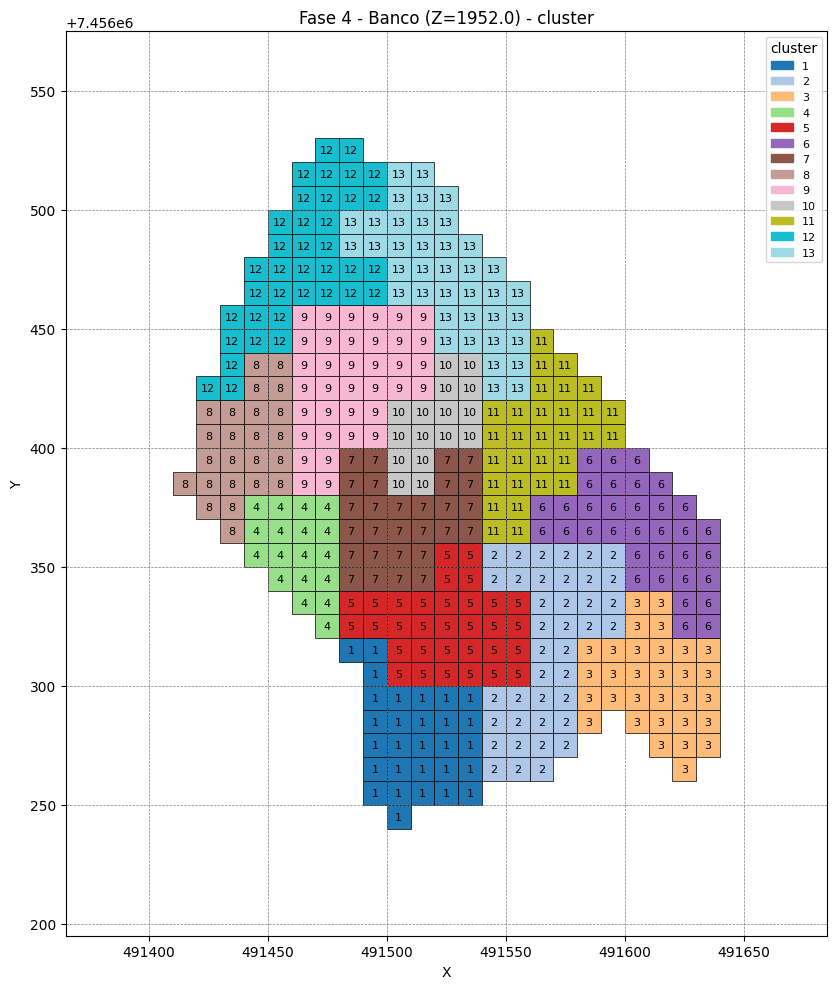

In [32]:
tbsh.plot_fase_banco(df_fb, 'cluster')

In [ ]:
df_mina_sim = mina_df.copy()


print("df_mina simulado:")
print(df_mina_sim.head())
print("\nFases y Bancos presentes:")
print(df_mina_sim.groupby(['fase', 'banco']).size())

# 2. Definir parámetros
fases_a_procesar = sorted(df_mina_sim['fase'].unique()) # Procesar todas las fases encontradas
clustering_params = {
    'max_cluster_size': 50,
    'target_num_clusters_per_bench': 4, # Target por banco
    'distancia_adyacencia': 10.0,       # Ajustar a la escala x,y
    'wd': 2.5,
    'wg': 2,
    'r': 0.5,                          # Factor si material es distinto
    'penalty_factor_c': 0.001,           # Penalización si clusters de abajo difieren
    'banco_col': 'banco'               # Nombre de la columna de banco
}

# 3. Ejecutar el proceso completo
df_mina_clustered, cluster_details = aux.cluster_mina_por_fase_banco(
    df_mina=df_mina_sim,
    fases_a_procesar=fases_a_procesar,
    **clustering_params
)

# 4. Verificar resultados en el DataFrame principal
print("\n--- Verificación de Resultados en df_mina ---")
print(df_mina_clustered[['id', 'fase', 'banco', 'final_cluster_id', 'final_cluster_label']].head(10))
print("\nDistribución de Clusters Finales por Banco:")
print(df_mina_clustered[df_mina_clustered['final_cluster_id'] != -1].groupby(['fase', 'banco', 'final_cluster_label']).size())


df_mina simulado:
          x          y       z        au       cpy      cueq       cus  \
0  491425.0  7456205.0  1968.0  0.288929  1.124707  0.712658  0.022003   
1  491435.0  7456195.0  1968.0  0.266522  1.057851  0.640223  0.021141   
2  491445.0  7456195.0  1968.0  0.243283  2.427782  0.531022  0.019991   
3  491455.0  7456195.0  1968.0  0.243283  2.427782  0.531022  0.019991   
4  491435.0  7456205.0  1968.0  0.288929  1.124707  0.712658  0.022003   

        cut   density  material        py    recg_au    recg_cu     tasox  \
0  0.550661  2.615598         8  0.401511  69.001505  87.011938  0.039957   
1  0.491924  2.626056         8  0.197908  68.839492  87.471598  0.042976   
2  0.396348  2.637350         6  0.399009  68.633711  87.659524  0.050438   
3  0.396348  2.637350         6  0.399009  68.633711  87.659524  0.050438   
4  0.550661  2.615598         8  0.401511  69.001505  87.011938  0.039957   

   tipomineral  fase  id  banco  
0            2     4   1     22  
1     

In [4]:
df_mina_clustered

x          y       z        au       cpy      cueq       cus  \
0      491425.0  7456205.0  1968.0  0.288929  1.124707  0.712658  0.022003   
1      491435.0  7456195.0  1968.0  0.266522  1.057851  0.640223  0.021141   
2      491445.0  7456195.0  1968.0  0.243283  2.427782  0.531022  0.019991   
3      491455.0  7456195.0  1968.0  0.243283  2.427782  0.531022  0.019991   
4      491435.0  7456205.0  1968.0  0.288929  1.124707  0.712658  0.022003   
...         ...        ...     ...       ...       ...       ...       ...   
91277  491985.0  7456545.0  2320.0  0.010000  0.043324  0.015000  0.001000   
91278  491975.0  7456555.0  2320.0  0.010000  0.043324  0.015000  0.001000   
91279  491985.0  7456555.0  2320.0  0.010000  0.043324  0.015000  0.001000   
91280  491975.0  7456565.0  2320.0  0.017194  0.112734  0.039031  0.006303   
91281  491975.0  7456575.0  2320.0  0.017194  0.112734  0.039031  0.006303   

            cut   density  material        py    recg_au    recg_cu     tasox  \
0      0.550661  2.615598         8  0.401511  69.001505  87.011938  0.039957   
1      0.491924  2.626056         8  0.197908  68.839492  87.471598  0.042976   
2      0.396348  2.637350         6  0.399009  68.633711  87.659524  0.050438   
3      0.396348  2.637350         6  0.399009  68.633711  87.659524  0.050438   
4      0.550661  2.615598         8  0.401511  69.001505  87.011938  0.039957   
...         ...       ...       ...       ...        ...        ...       ...   
91277  0.015000  2.352000         0  0.000000   0.000000   0.000000  0.066667   
91278  0.015000  2.352000         0  0.000000   0.000000   0.000000  0.066667   
91279  0.015000  2.352000         0  0.000000   0.000000   0.000000  0.066667   
91280  0.039031  2.352000         0  0.000000   0.000000   0.000000  0.161474   
91281  0.039031  2.352000         0  0.000000   0.000000   0.000000  0.161474   

       tipomineral  fase     id  banco  final_cluster_id final_cluster_label  
0                2     4      1     22                 1           F4_B22_C1  
1                2     4      2     22                 1           F4_B22_C1  
2                2     4      3     22                 1           F4_B22_C1  
3                2     4      4     22                 1           F4_B22_C1  
4                2     4      5     22                 1           F4_B22_C1  
...            ...   ...    ...    ...               ...                 ...  
91277            0     3  91278      2                 6            F3_B2_C6  
91278            0     3  91279      2                 6            F3_B2_C6  
91279            0     3  91280      2                 6            F3_B2_C6  
91280            0     3  91281      2                 6            F3_B2_C6  
91281            0     3  91282      2                 6            F3_B2_C6  

[91282 rows x 20 columns]

In [5]:
df_mina_clustered.to_csv("df_mina_clustered_4.csv", index=False)

In [2]:
df_mina_clustered = pd.read_csv("df_mina_clustered_4.csv")
df_mina_clustered.rename(columns={'final_cluster_id': 'cluster'}, inplace=True)
df = df_mina_clustered.copy()

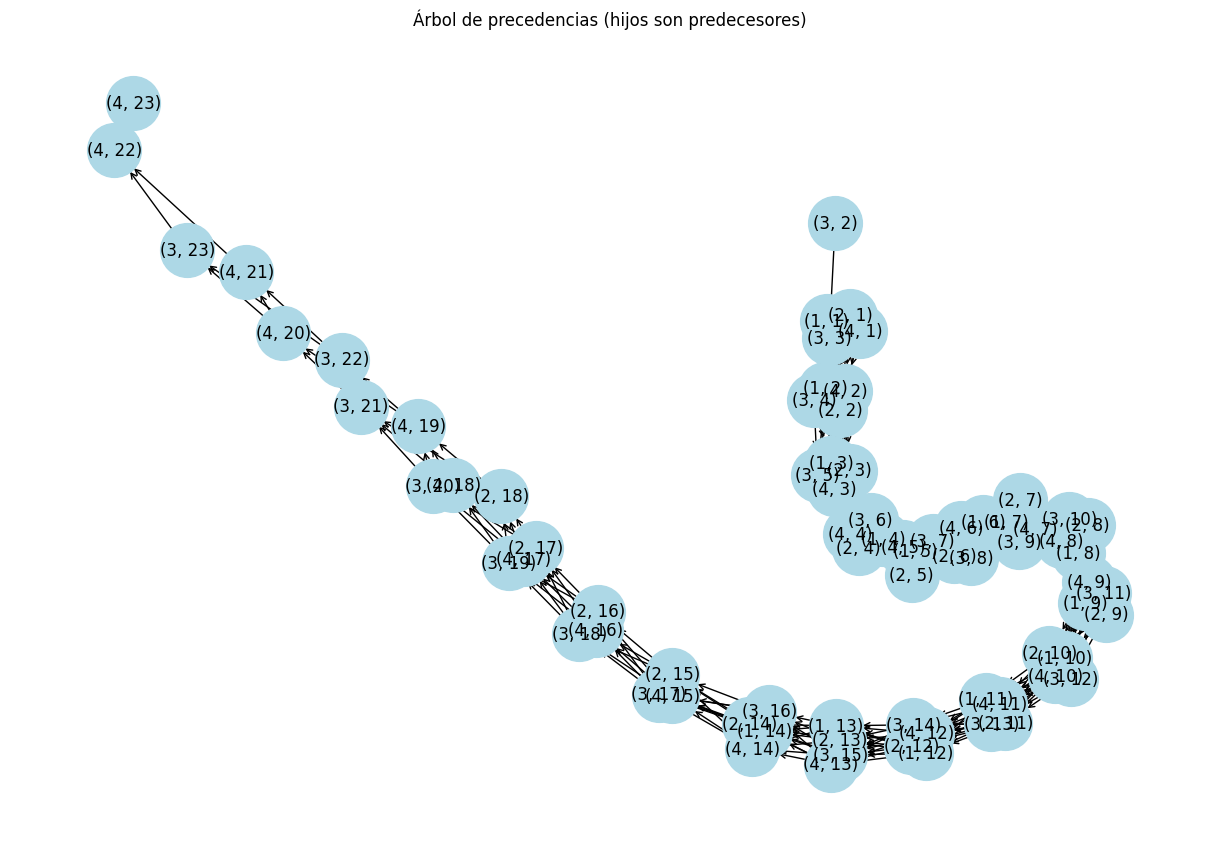

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear el grafo
G = nx.DiGraph()

# Agregar las aristas del árbol
for nodo, predecesores in cleaned_tree.items():
    for pred in predecesores:
        G.add_edge(nodo, pred)

# Dibujar el grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # o usa shell_layout, kamada_kawai_layout, etc.
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, arrows=True, arrowstyle='->')
plt.title("Árbol de precedencias (hijos son predecesores)")
plt.show()

### Calculo de arcos locales

In [3]:
arcs = aux.Global_Vertical_Arc_Calculation(df)

In [7]:
CV[0]

np.float64(0.7695154803382049)

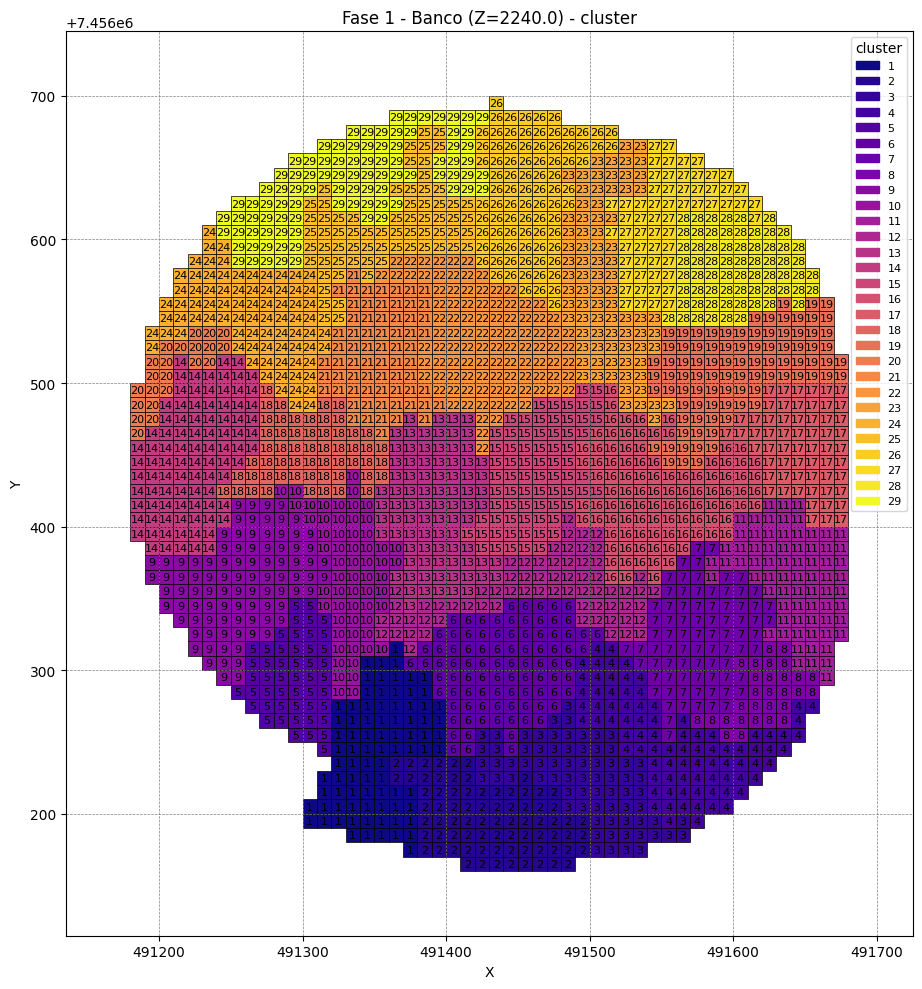

In [43]:
tbsh.plot_fase_banco(df_sup, 'cluster')

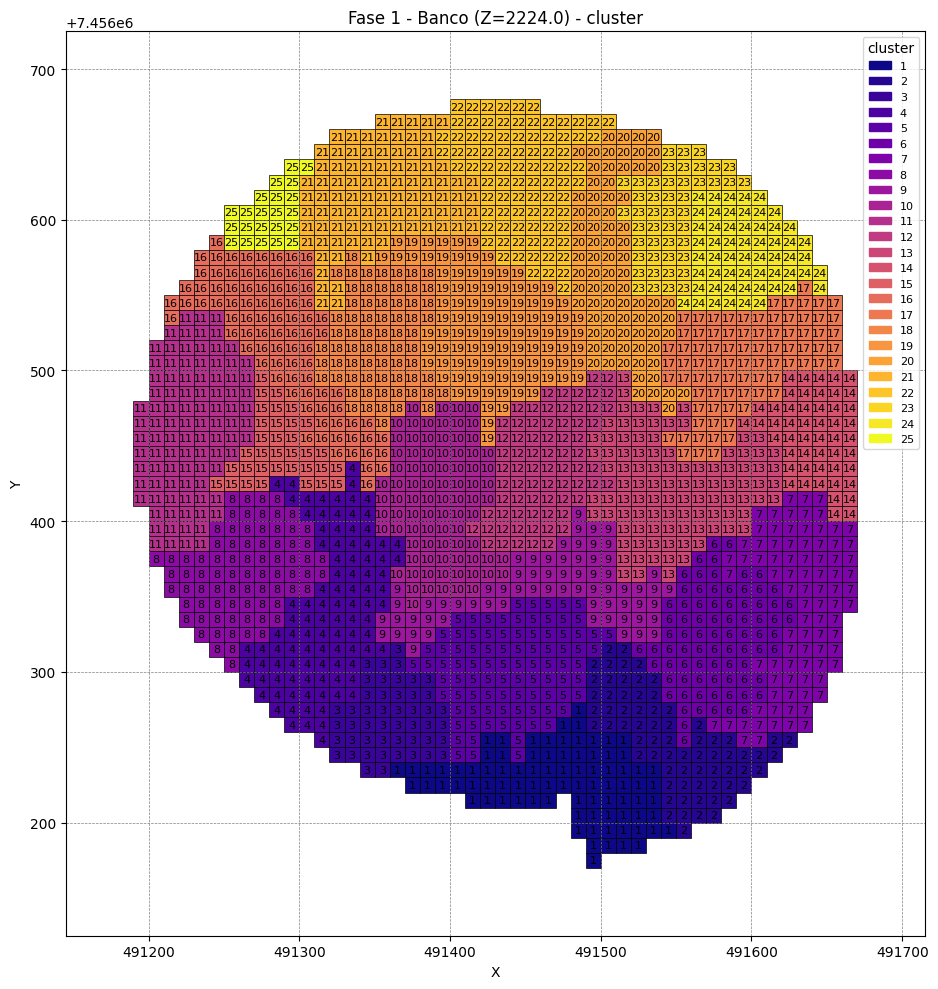

In [44]:
tbsh.plot_fase_banco(df_inf, 'cluster')

Tratando 'cluster' como Categórica (29 valores únicos).


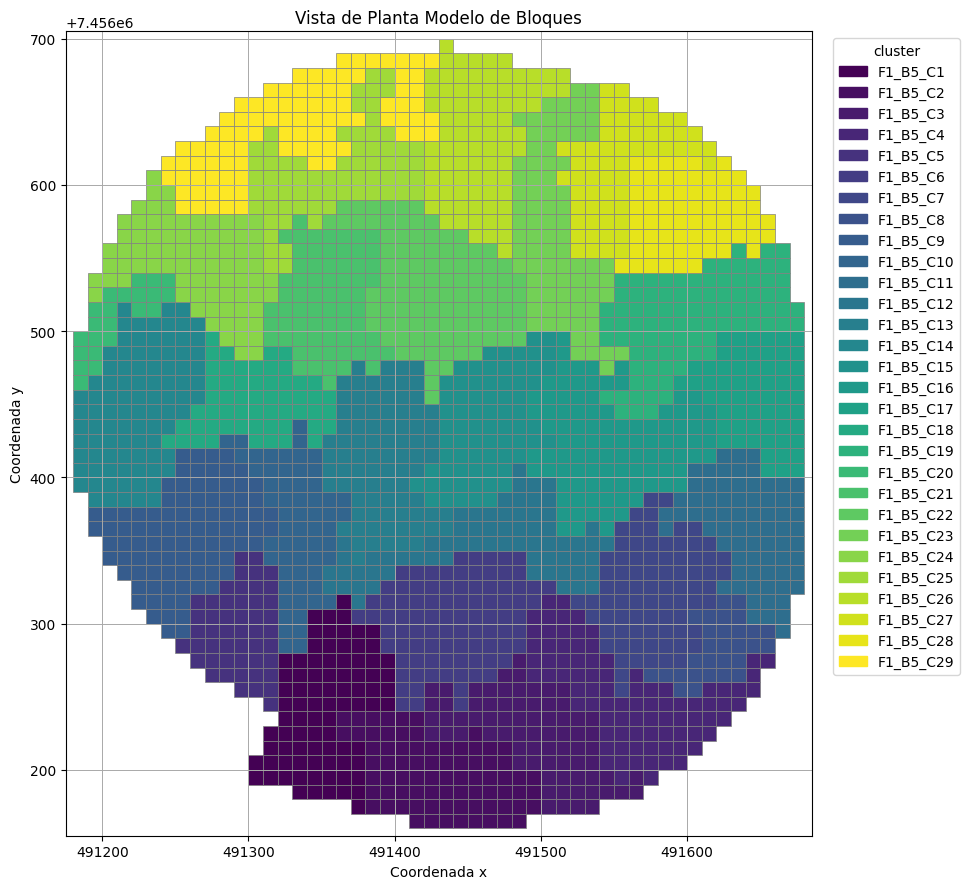

In [ ]:
df_mina_clustered = pd.read_csv("df_mina_clustered_4.csv")
df = df_mina_clustered.copy()
f,b = 1,5
df = df[(df['fase']==f)&(df['banco']==b)]
df.reset_index(inplace=True, drop=True)
df.rename(columns={'final_cluster_label': 'cluster'}, inplace=True)
aux.plot_mine_blocks_adv(df, 'cluster')


In [10]:
A = tbsh.Calculate_Adjency_Matrix(df, 10)
df2 = tbsh.Shape_Refinement_Tabesh(df, A, Min_Cluster_Length=20, Iterations_PostProcessing= 50)

========PostProcessing Results========
Total de clusters: 29
Tiempo: 63.86706614494324


In [6]:
df2[0]

x          y       z        au       cpy      cueq       cus  \
0     491375.0  7456175.0  2240.0  0.026555  0.050147  0.017366  0.001928   
1     491385.0  7456175.0  2240.0  0.024233  0.125937  0.043612  0.012661   
2     491395.0  7456175.0  2240.0  0.024233  0.125937  0.043612  0.012661   
3     491415.0  7456165.0  2240.0  0.010305  0.130463  0.045179  0.014165   
4     491425.0  7456165.0  2240.0  0.010097  0.149698  0.051840  0.013722   
...        ...        ...     ...       ...       ...       ...       ...   
2132  491525.0  7456665.0  2240.0  0.077704  0.382872  0.132589  0.083393   
2133  491535.0  7456665.0  2240.0  0.077704  0.382872  0.132589  0.083393   
2134  491545.0  7456665.0  2240.0  0.079933  0.367093  0.127124  0.073981   
2135  491555.0  7456665.0  2240.0  0.079933  0.367093  0.127124  0.073981   
2136  491435.0  7456695.0  2240.0  0.050178  0.362285  0.125459  0.064180   

           cut   density  material   py  recg_au  recg_cu     tasox  \
0     0.017366  2.472998         0  0.0      0.0      0.0  0.111023   
1     0.043612  2.470923         0  0.0      0.0      0.0  0.290298   
2     0.043612  2.470923         0  0.0      0.0      0.0  0.290298   
3     0.045179  2.485071         0  0.0      0.0      0.0  0.313523   
4     0.051840  2.512373         0  0.0      0.0      0.0  0.264695   
...        ...       ...       ...  ...      ...      ...       ...   
2132  0.132589  2.604985         1  0.0      0.0      0.0  0.628958   
2133  0.132589  2.604985         1  0.0      0.0      0.0  0.628958   
2134  0.127124  2.613966         1  0.0      0.0      0.0  0.581956   
2135  0.127124  2.613966         1  0.0      0.0      0.0  0.581956   
2136  0.125459  2.588062         1  0.0      0.0      0.0  0.511557   

      tipomineral  fase     id  banco  final_cluster_id    cluster  
0               0     1  55385      5                 1   F1_B5_C1  
1               0     1  55386      5                 2   F1_B5_C2  
2               0     1  55387      5                 2   F1_B5_C2  
3               0     1  55410      5                 2   F1_B5_C2  
4               0     1  55411      5                 2   F1_B5_C2  
...           ...   ...    ...    ...               ...        ...  
2132            1     1  69001      5                23  F1_B5_C23  
2133            1     1  69002      5                23  F1_B5_C23  
2134            1     1  69003      5                27  F1_B5_C27  
2135            1     1  69028      5                27  F1_B5_C27  
2136            1     1  69547      5                26  F1_B5_C26  

[2137 rows x 20 columns]

Tratando 'cluster' como Categórica (29 valores únicos).


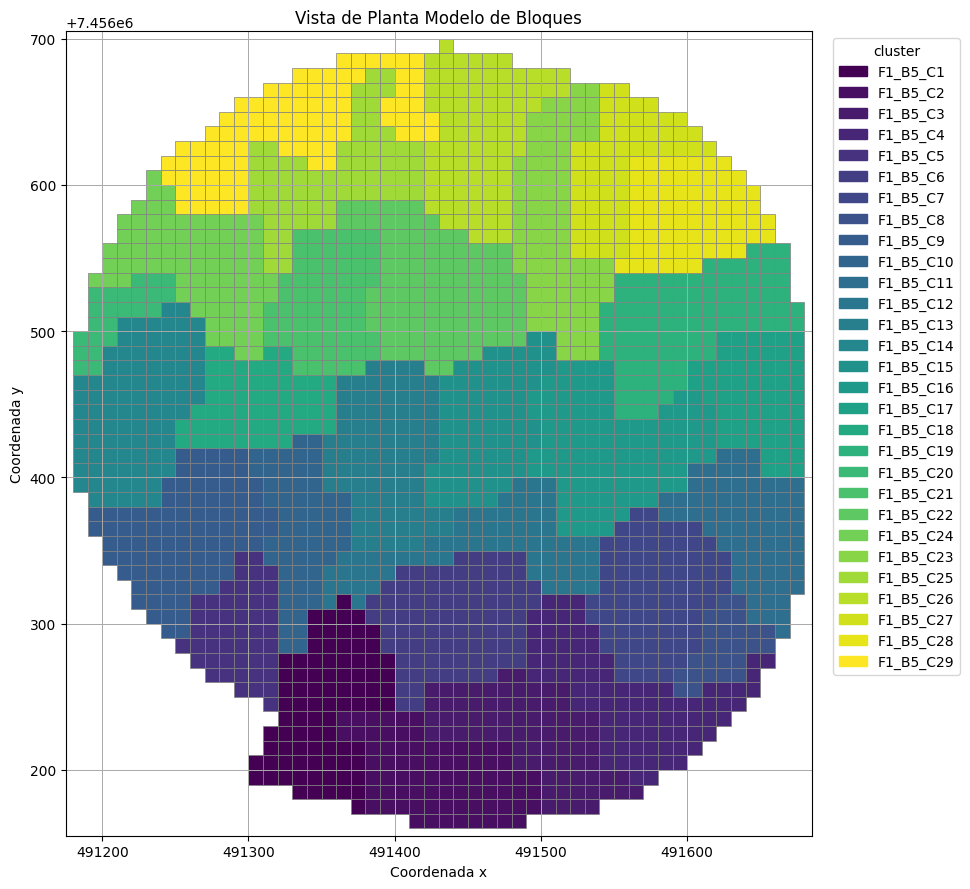

In [11]:
aux.plot_mine_blocks_adv(df2[0], 'cluster')

In [4]:
df_copy = df_mina_clustered.copy()

In [5]:
df_copy['final_cluster_label']

0        F4_B22_C1
1        F4_B22_C1
2        F4_B22_C1
3        F4_B22_C1
4        F4_B22_C1
           ...    
91277     F3_B2_C6
91278     F3_B2_C6
91279     F3_B2_C6
91280     F3_B2_C6
91281     F3_B2_C6
Name: final_cluster_label, Length: 91282, dtype: object

Las siguientes celdas hacen graficos por banco de la fase 1 para comparar los clusters

In [ ]:
f = 1
fase_data = df_copy[df_copy['fase'] == f]
x_min_global = fase_data['x'].min() - 5*10
x_max_global = fase_data['x'].max() + 5*10
y_min_global = fase_data['y'].min() - 5*10
y_max_global = fase_data['y'].max() + 5*10

for b in range(1, 10):
    df_ = df_copy[(df_copy['fase'] == f) & (df_copy['banco'] == b)]
    tbsh.plot_fase_banco(df_, column_hue='final_cluster_id',
                         xlim=(x_min_global, x_max_global),
                         ylim=(y_min_global, y_max_global))

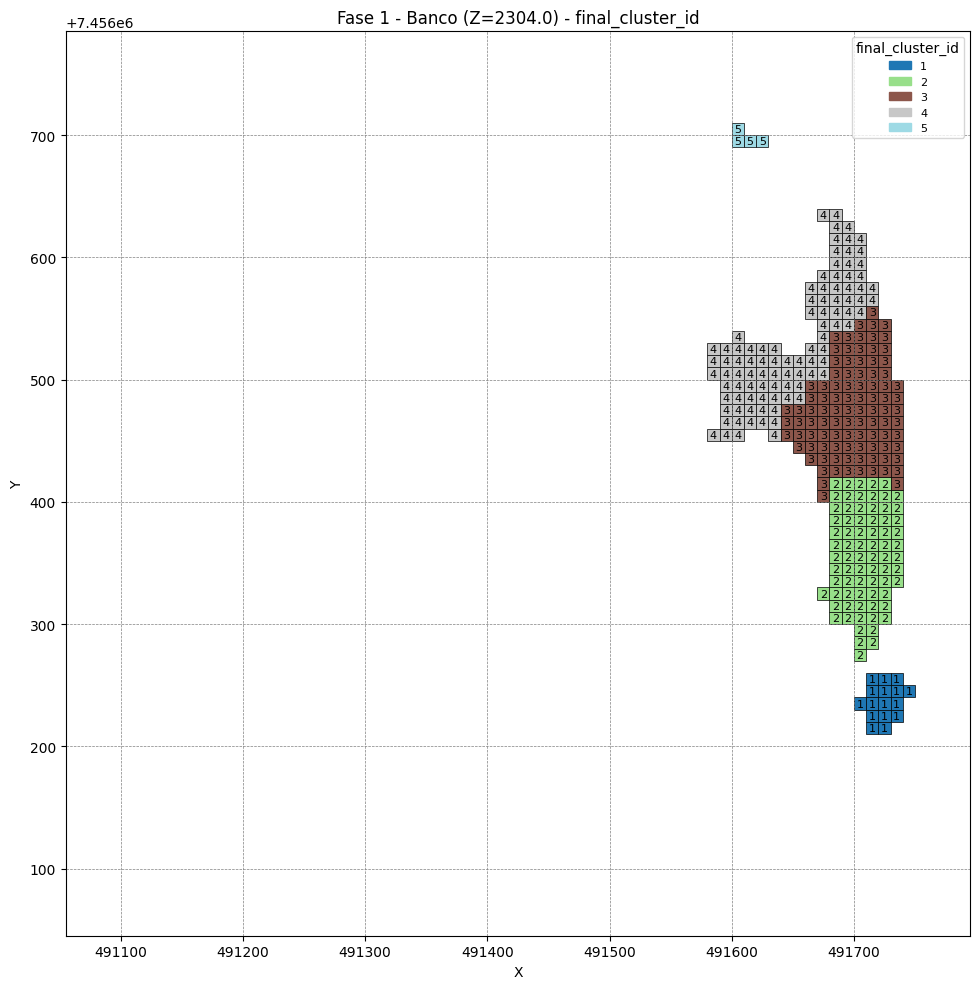

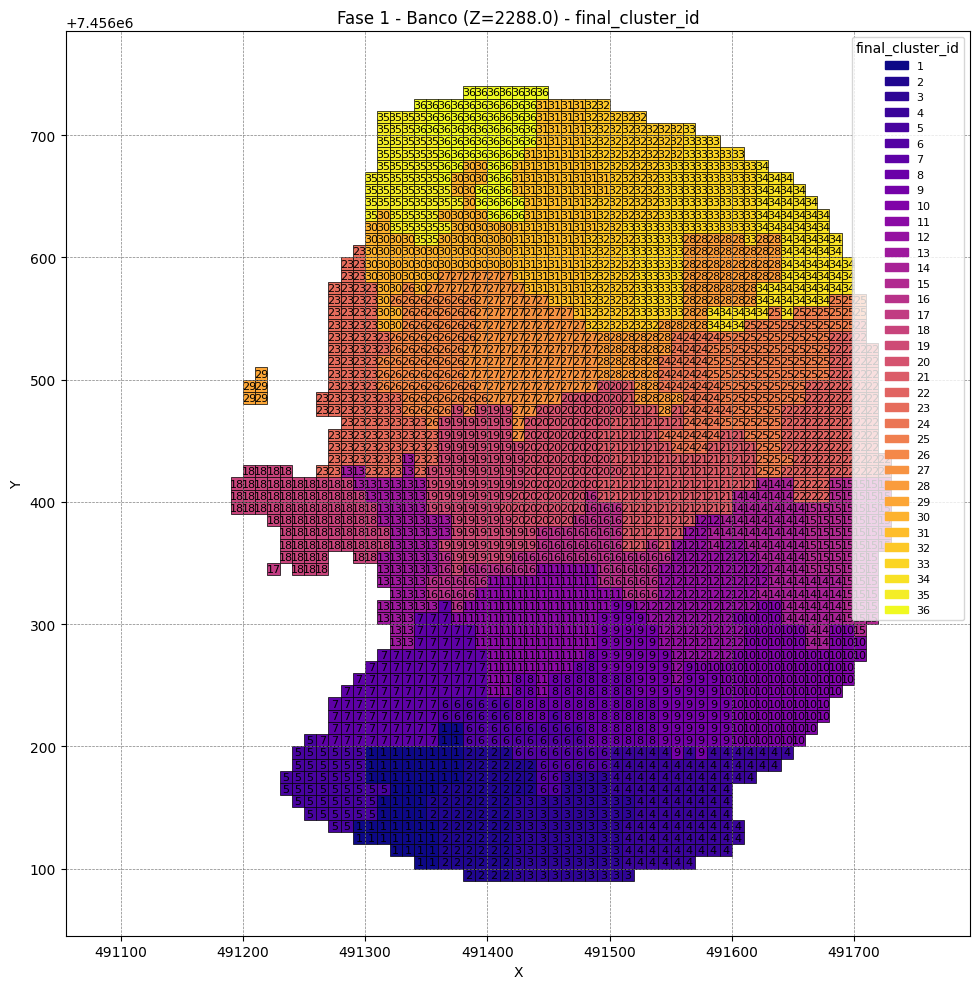

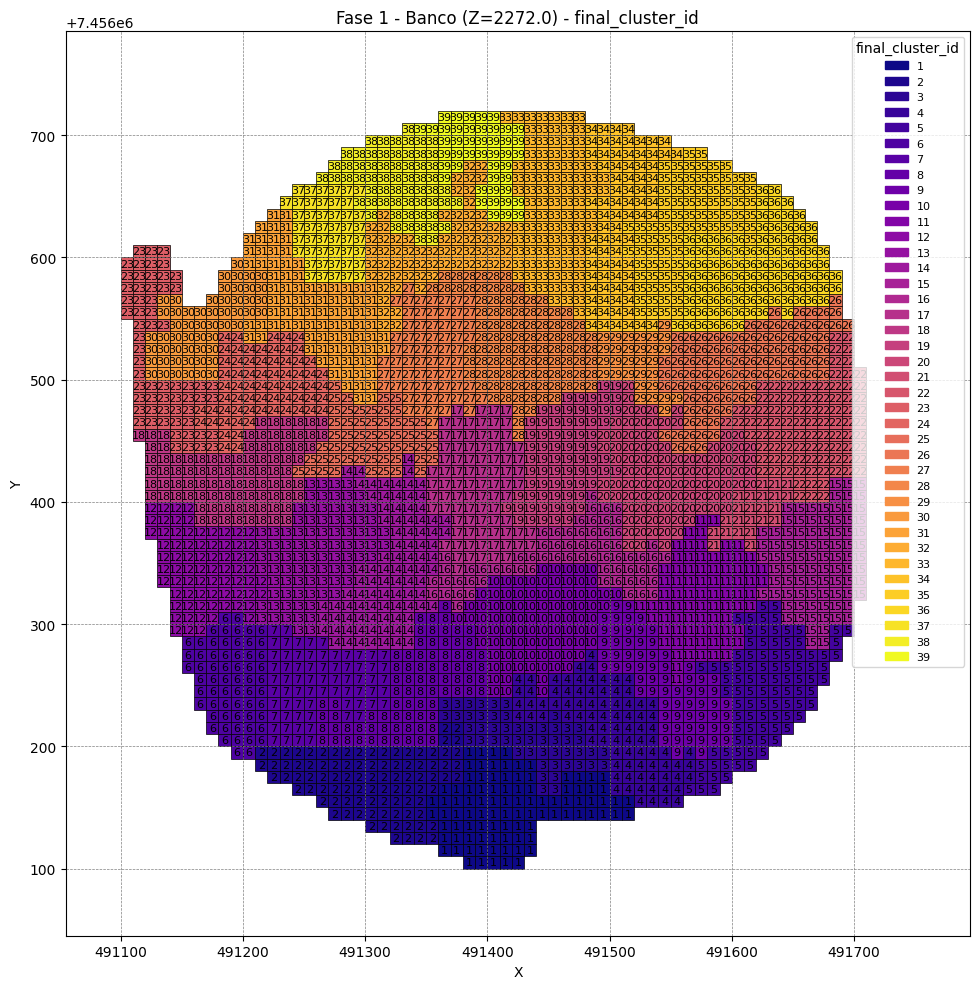

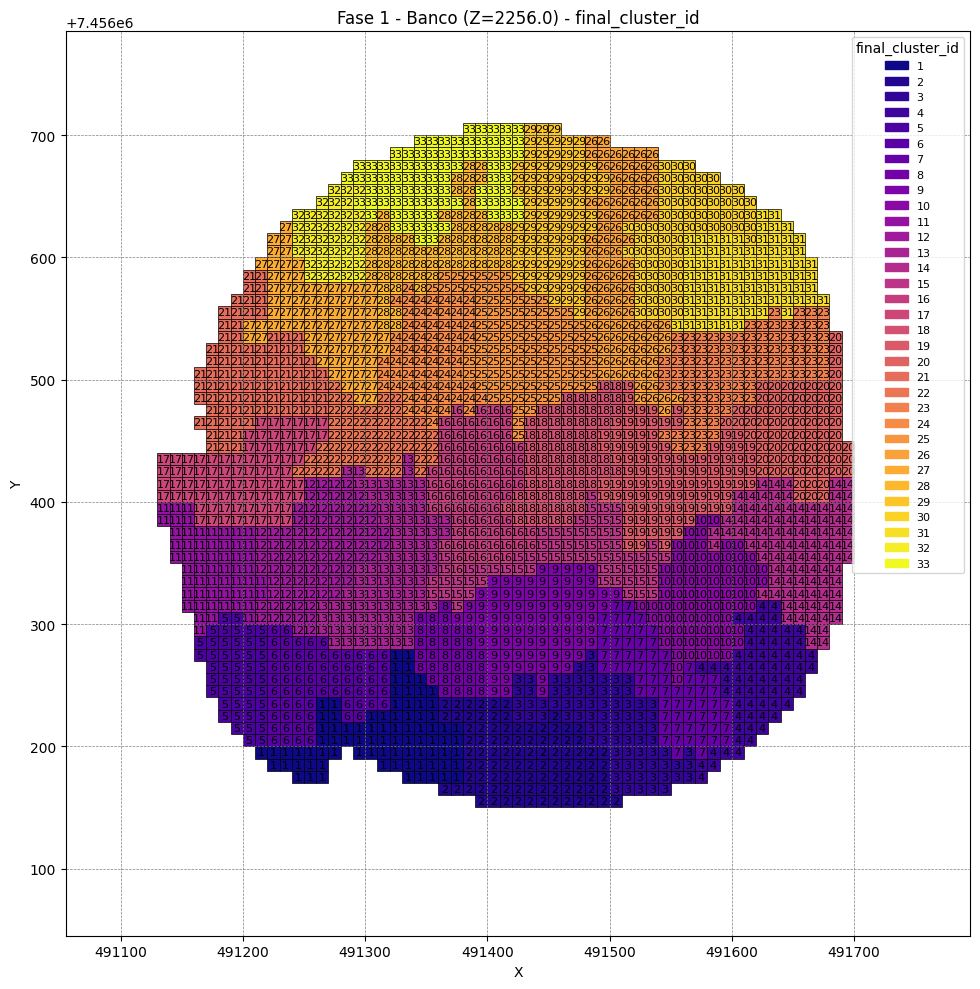

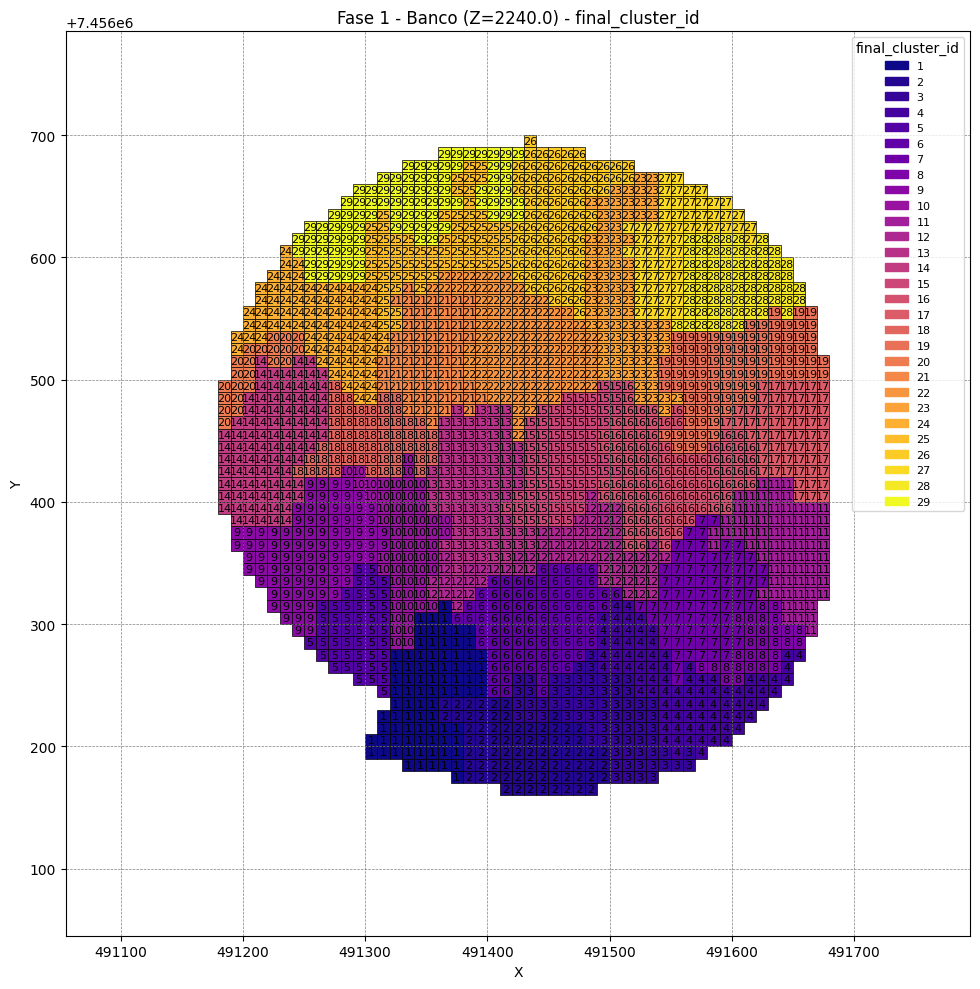

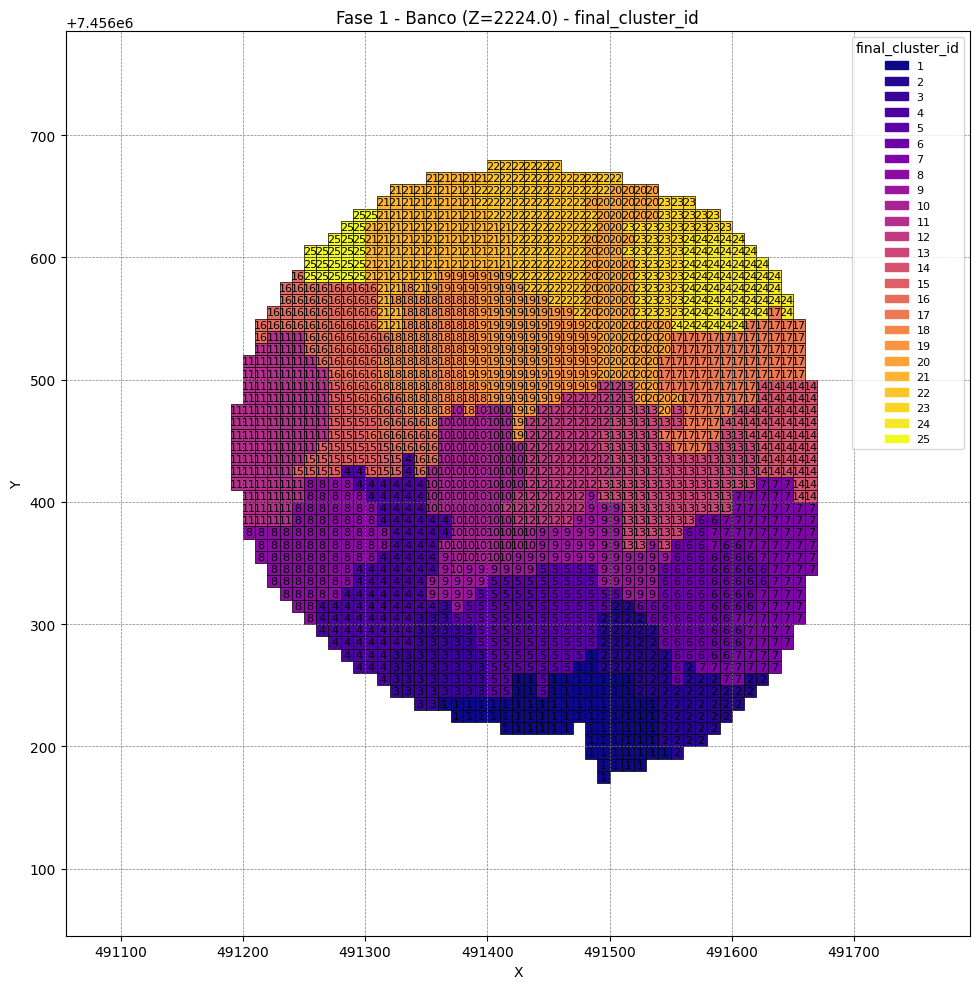

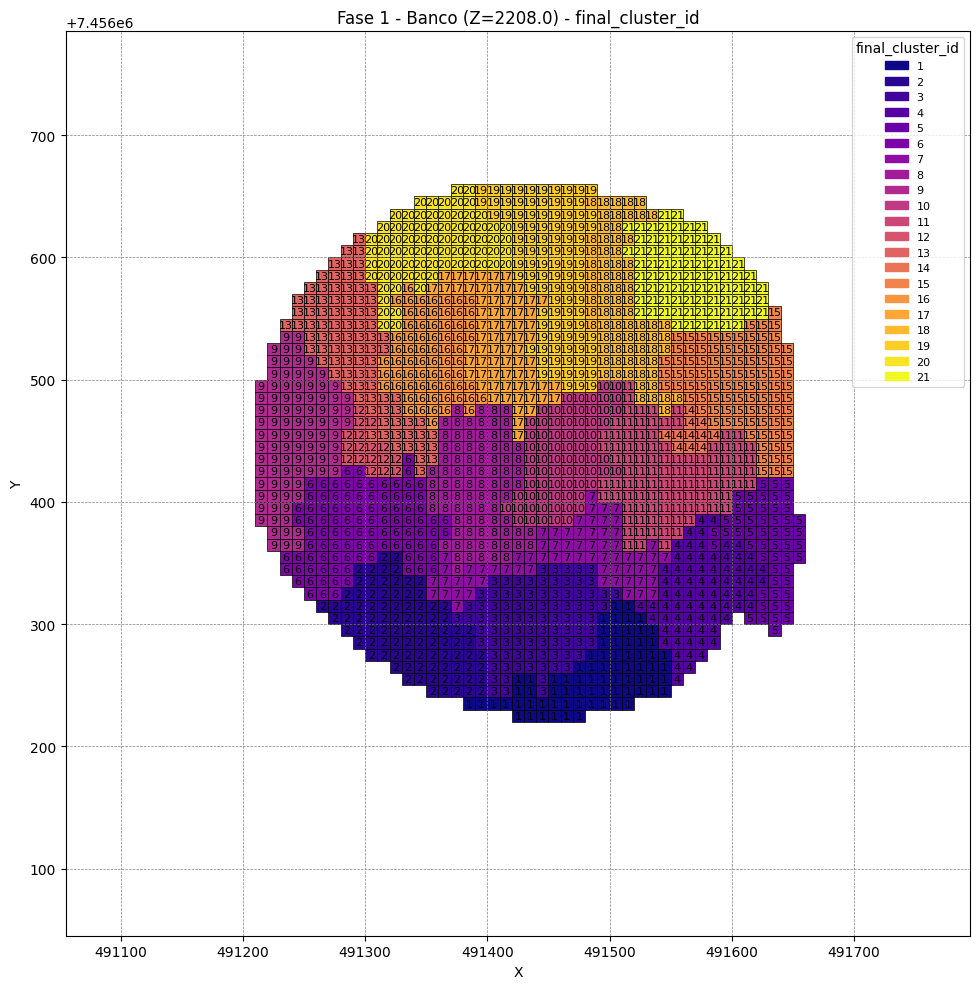

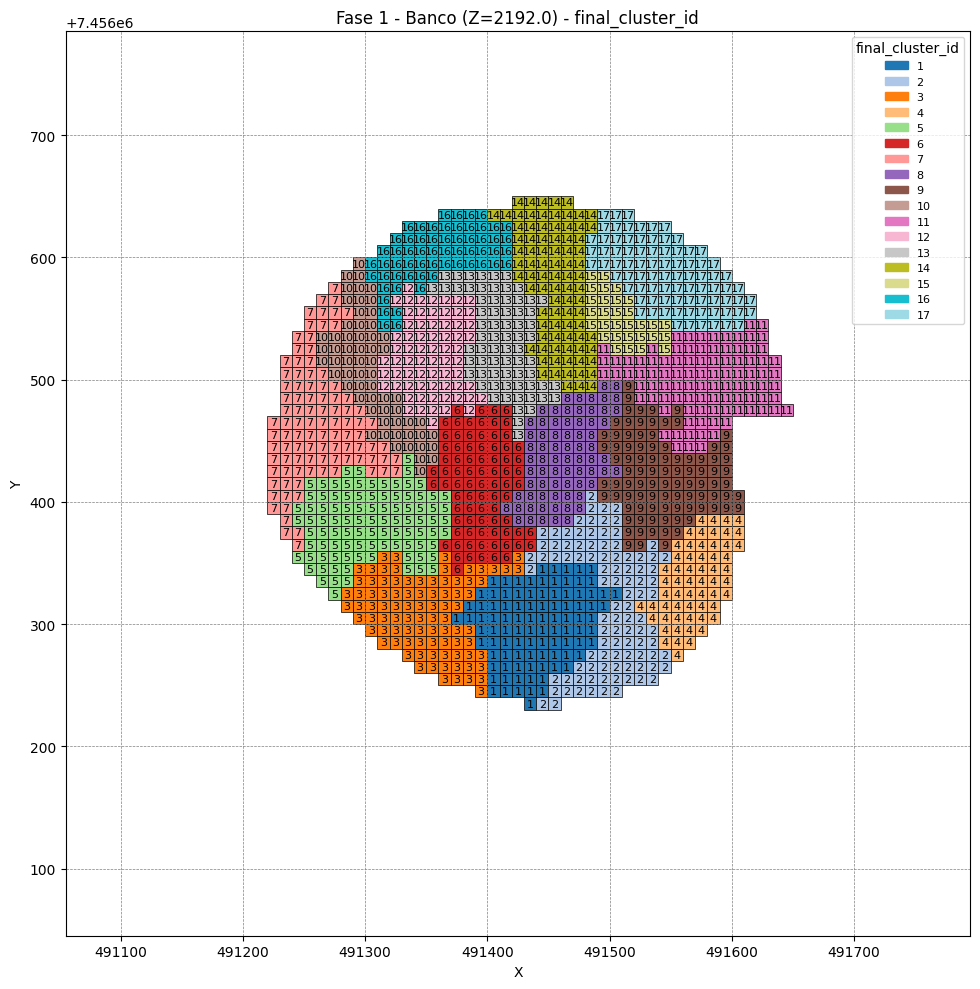

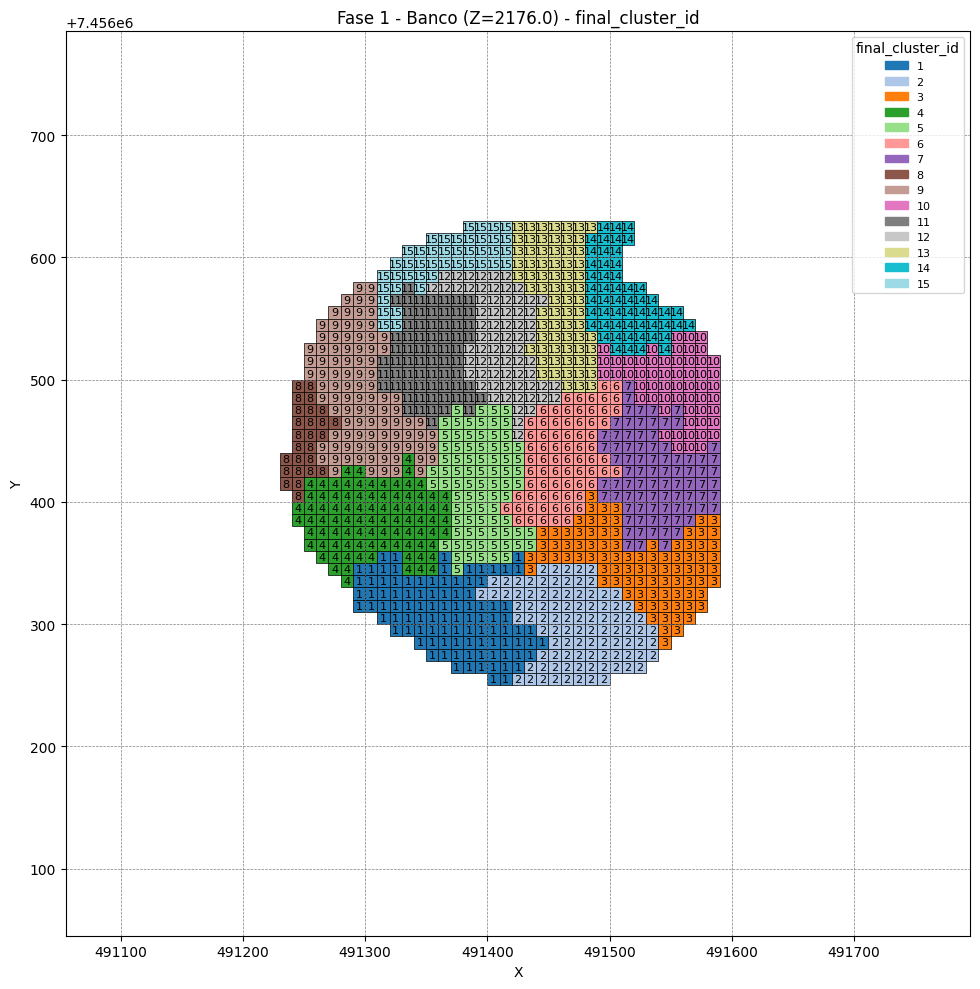

In [9]:
for b in range(1, 10):
    df_ = df_copy[(df_copy['fase'] == f) & (df_copy['banco'] == b)]
    tbsh.plot_fase_banco(df_, column_hue='final_cluster_id',
                         xlim=(x_min_global, x_max_global),
                         ylim=(y_min_global, y_max_global))

In [59]:
df

x          y       z        au       cpy      cueq       cus  \
0      491425.0  7456205.0  1968.0  0.288929  1.124707  0.712658  0.022003   
1      491435.0  7456195.0  1968.0  0.266522  1.057851  0.640223  0.021141   
2      491445.0  7456195.0  1968.0  0.243283  2.427782  0.531022  0.019991   
3      491455.0  7456195.0  1968.0  0.243283  2.427782  0.531022  0.019991   
4      491435.0  7456205.0  1968.0  0.288929  1.124707  0.712658  0.022003   
...         ...        ...     ...       ...       ...       ...       ...   
91277  491985.0  7456545.0  2320.0  0.010000  0.043324  0.015000  0.001000   
91278  491975.0  7456555.0  2320.0  0.010000  0.043324  0.015000  0.001000   
91279  491985.0  7456555.0  2320.0  0.010000  0.043324  0.015000  0.001000   
91280  491975.0  7456565.0  2320.0  0.017194  0.112734  0.039031  0.006303   
91281  491975.0  7456575.0  2320.0  0.017194  0.112734  0.039031  0.006303   

            cut   density  material        py    recg_au    recg_cu     tasox  \
0      0.550661  2.615598         8  0.401511  69.001505  87.011938  0.039957   
1      0.491924  2.626056         8  0.197908  68.839492  87.471598  0.042976   
2      0.396348  2.637350         6  0.399009  68.633711  87.659524  0.050438   
3      0.396348  2.637350         6  0.399009  68.633711  87.659524  0.050438   
4      0.550661  2.615598         8  0.401511  69.001505  87.011938  0.039957   
...         ...       ...       ...       ...        ...        ...       ...   
91277  0.015000  2.352000         0  0.000000   0.000000   0.000000  0.066667   
91278  0.015000  2.352000         0  0.000000   0.000000   0.000000  0.066667   
91279  0.015000  2.352000         0  0.000000   0.000000   0.000000  0.066667   
91280  0.039031  2.352000         0  0.000000   0.000000   0.000000  0.161474   
91281  0.039031  2.352000         0  0.000000   0.000000   0.000000  0.161474   

       tipomineral  fase     id  banco  cluster global_cluster  
0                2     4      1     22      1.0    F4_B22_C1.0  
1                2     4      2     22      1.0    F4_B22_C1.0  
2                2     4      3     22      1.0    F4_B22_C1.0  
3                2     4      4     22      1.0    F4_B22_C1.0  
4                2     4      5     22      1.0    F4_B22_C1.0  
...            ...   ...    ...    ...      ...            ...  
91277            0     3  91278      2     17.0    F3_B2_C17.0  
91278            0     3  91279      2     17.0    F3_B2_C17.0  
91279            0     3  91280      2     17.0    F3_B2_C17.0  
91280            0     3  91281      2     17.0    F3_B2_C17.0  
91281            0     3  91282      2     17.0    F3_B2_C17.0  

[91282 rows x 20 columns]

In [3]:
df = pd.read_csv("df_mina_clustered_w_shape_refinement.csv")

Tratando 'cluster' como Categórica (18 valores únicos).
Tratando 'cluster' como Continua.
  Escala de color: min=1.00, max=100.00
Tratando 'cluster' como Continua.
  Escala de color: min=1.00, max=96.00
Tratando 'cluster' como Continua.
  Escala de color: min=1.00, max=118.00
Tratando 'cluster' como Continua.
  Escala de color: min=1.00, max=67.00
Tratando 'cluster' como Continua.
  Escala de color: min=1.00, max=61.00
Tratando 'cluster' como Continua.
  Escala de color: min=1.00, max=57.00
Tratando 'cluster' como Continua.
  Escala de color: min=1.00, max=46.00
Tratando 'cluster' como Continua.
  Escala de color: min=1.00, max=34.00


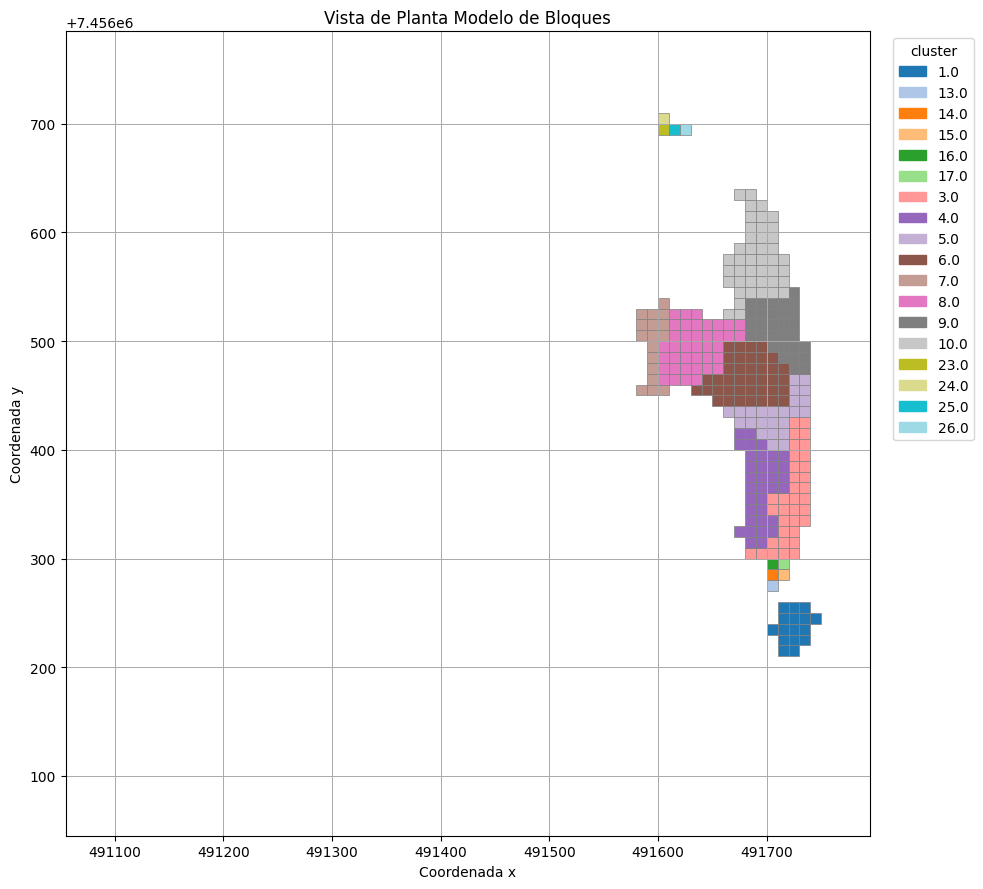

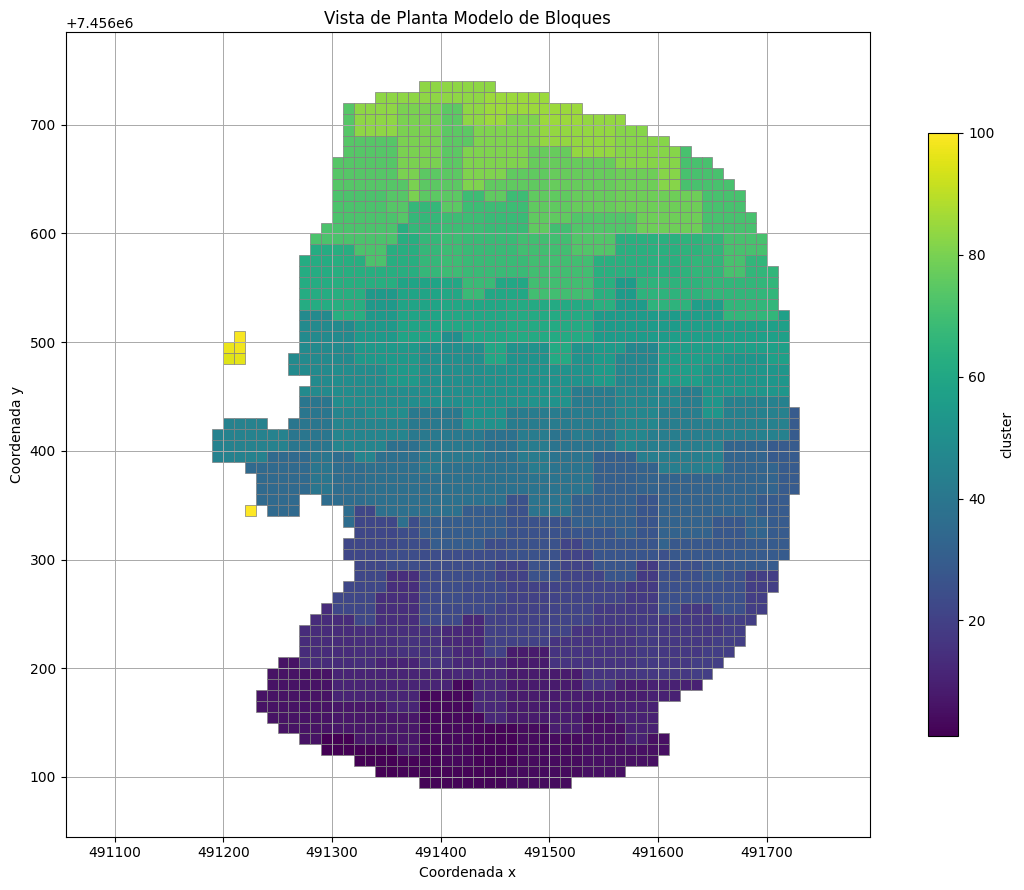

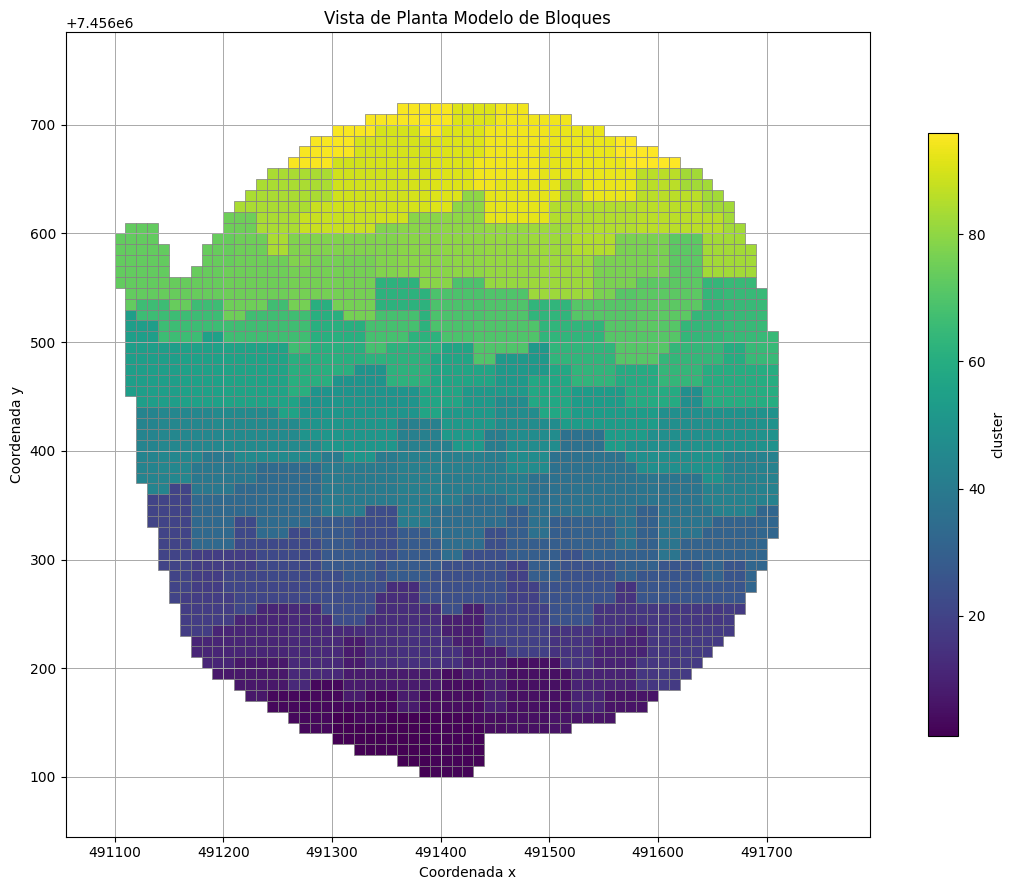

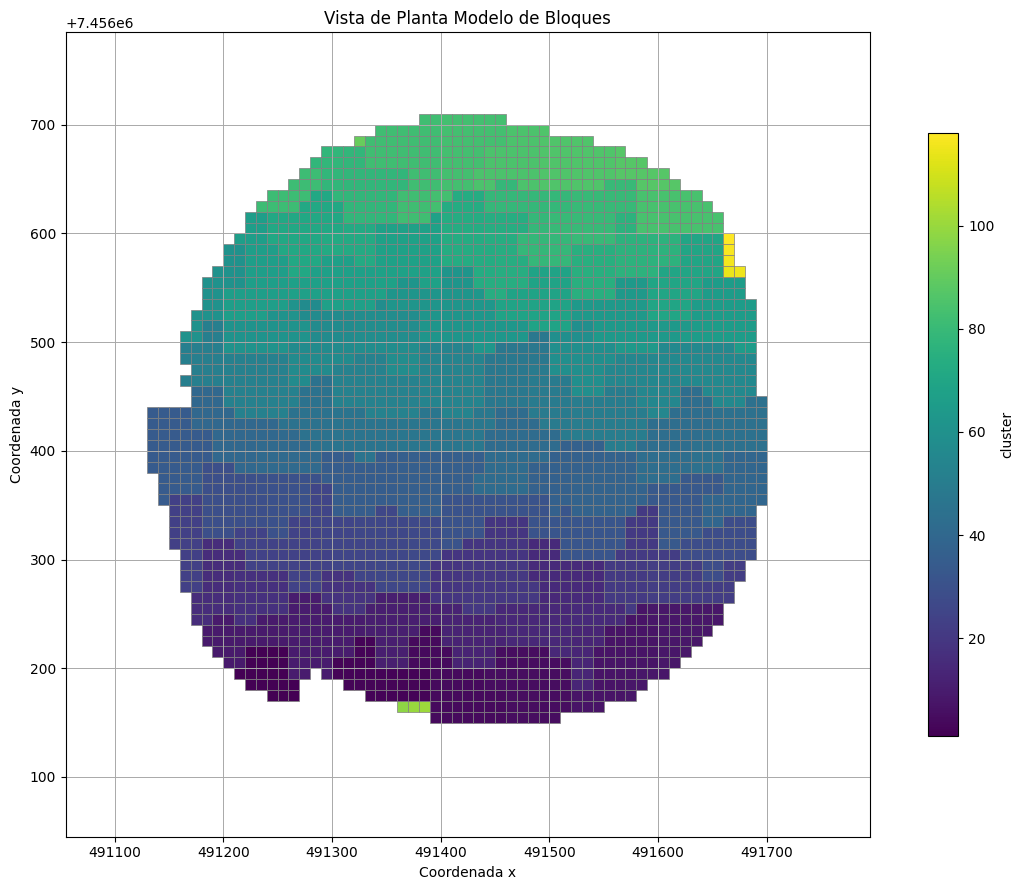

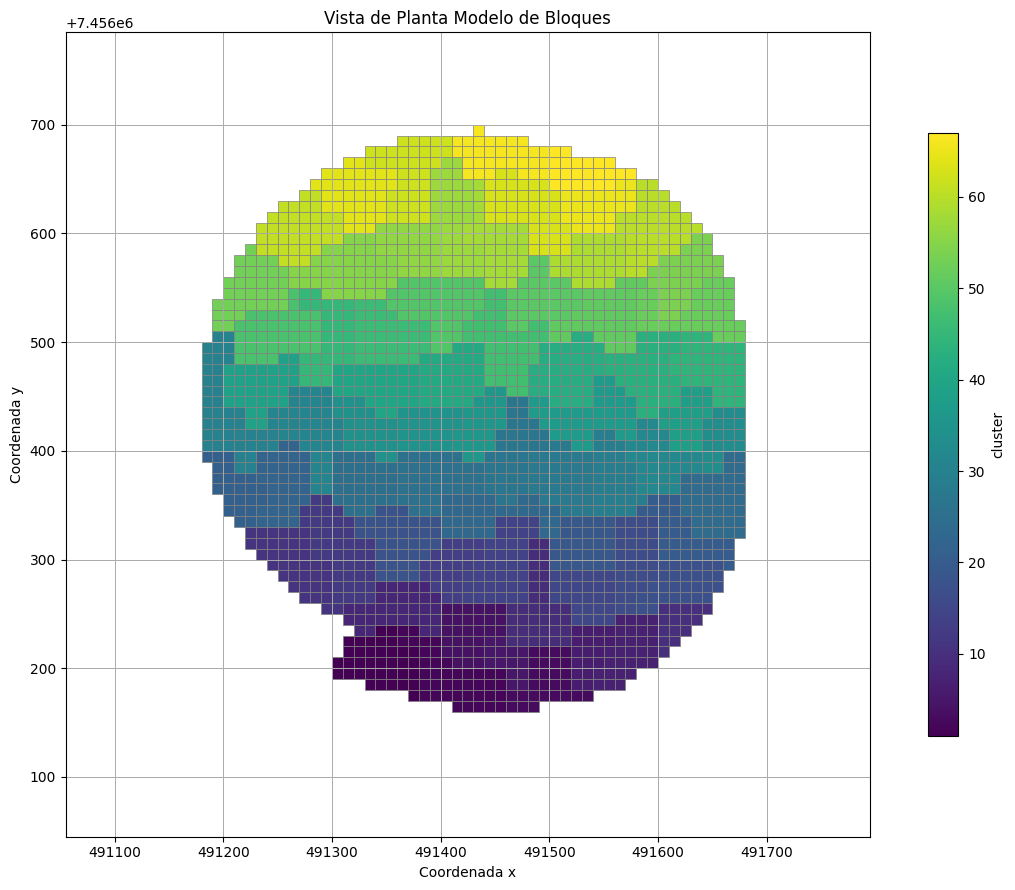

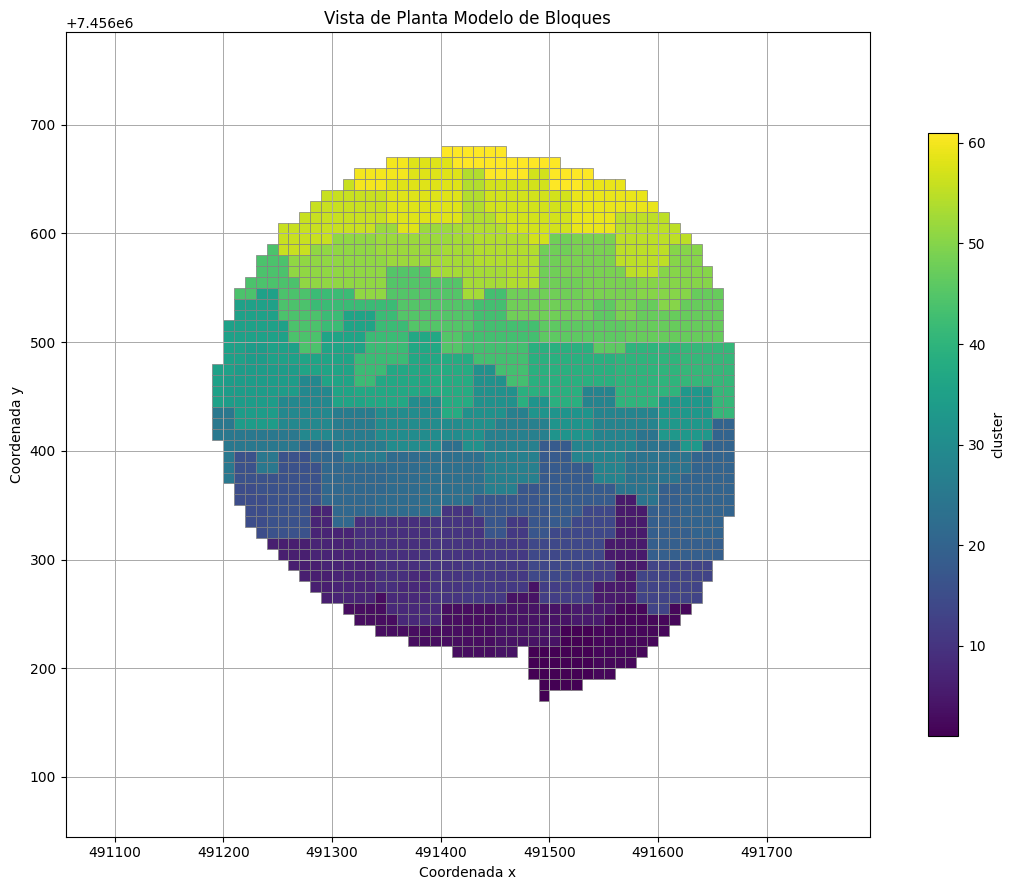

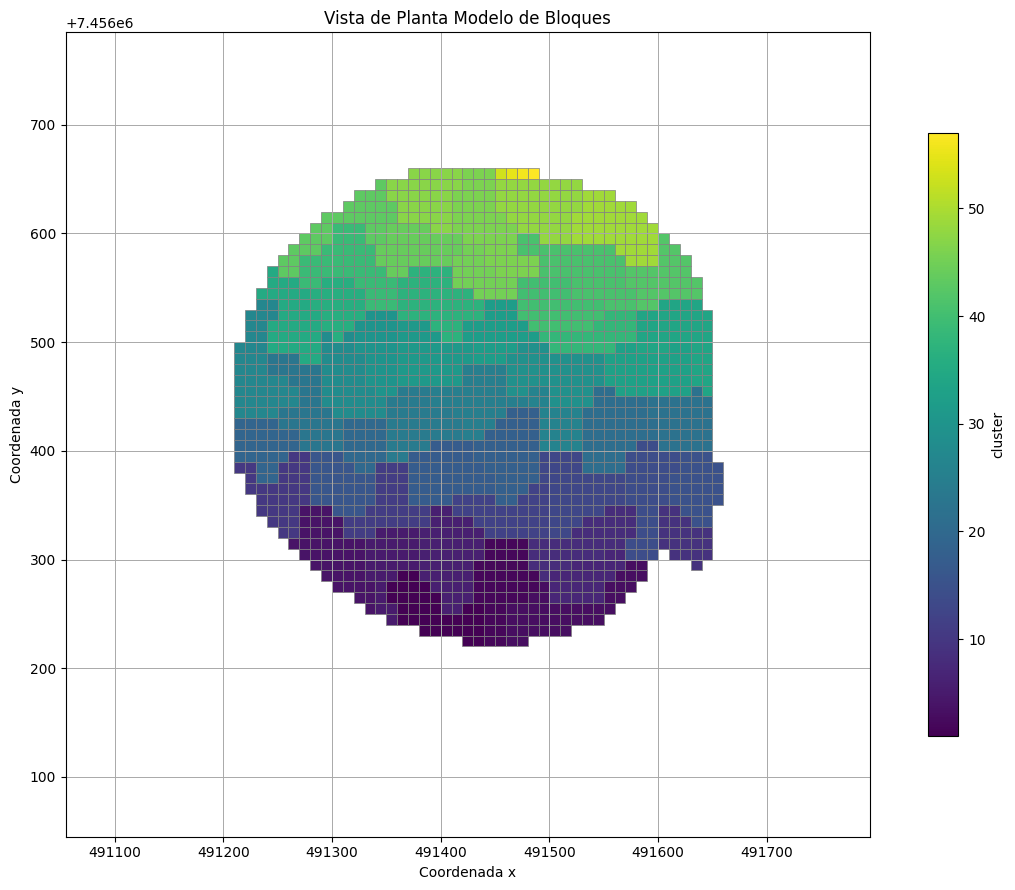

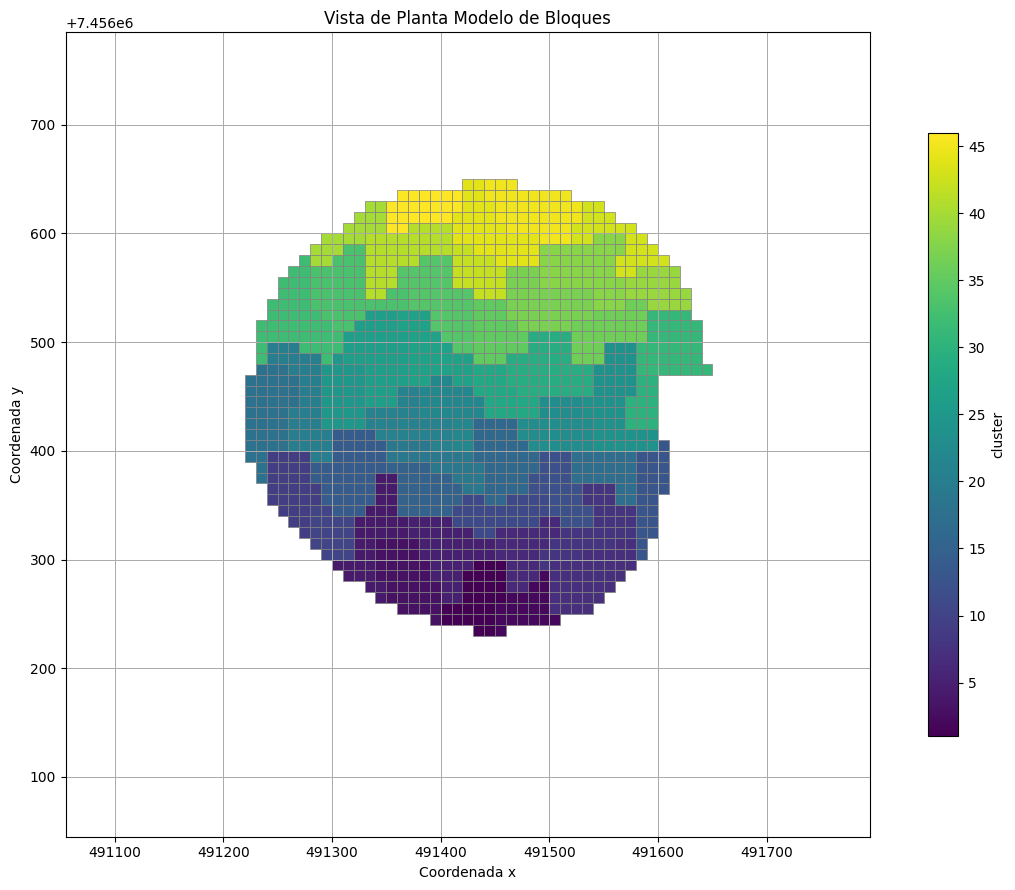

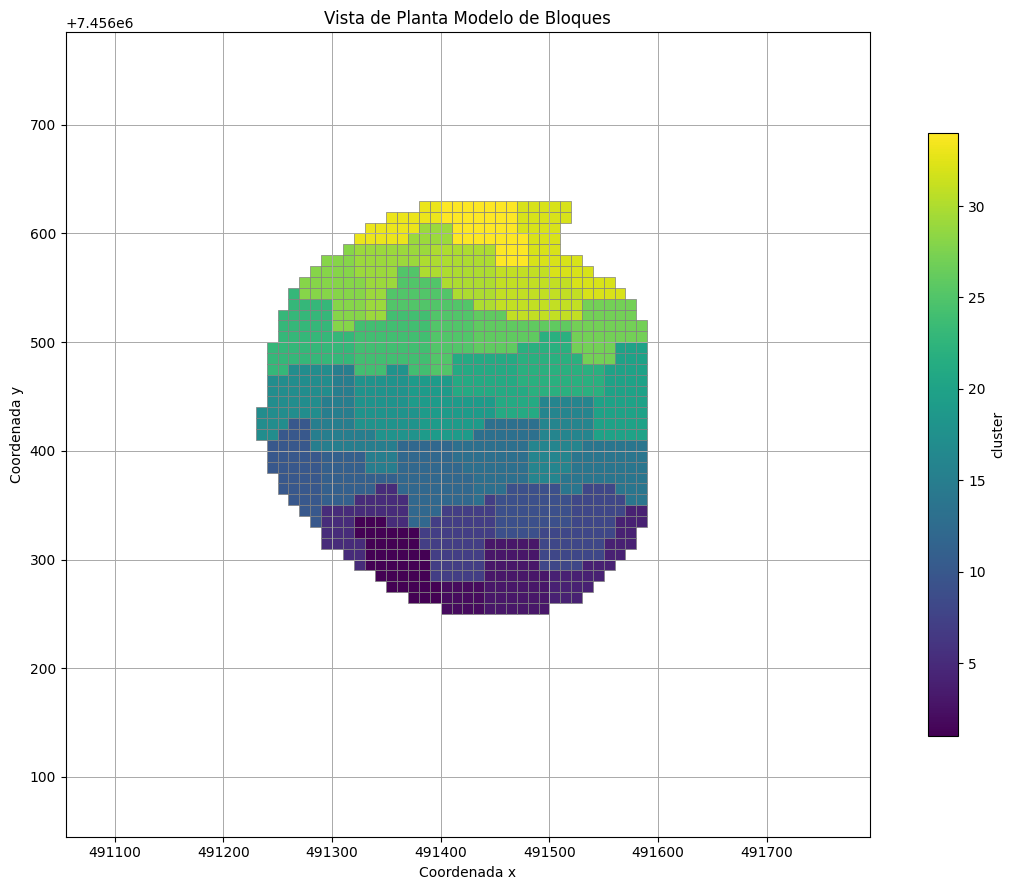

In [5]:
f = 1
df_copy = df.copy()
fase_data = df_copy[df_copy['fase'] == f]
x_min_global = fase_data['x'].min() - 5*10
x_max_global = fase_data['x'].max() + 5*10
y_min_global = fase_data['y'].min() - 5*10
y_max_global = fase_data['y'].max() + 5*10

for b in range(1, 10):
    df_ = df_copy[(df_copy['fase'] == f) & (df_copy['banco'] == b)]
    aux.plot_mine_blocks_adv(df_, color_by_col='cluster', xlim=(x_min_global, x_max_global),
                         ylim=(y_min_global, y_max_global), save=True, save_name=f'fase{f}banco{b}.png')


In [6]:
CV = aux.Coefficient_Variation(df)
CV[0]

np.float64(0.6436316107490445)

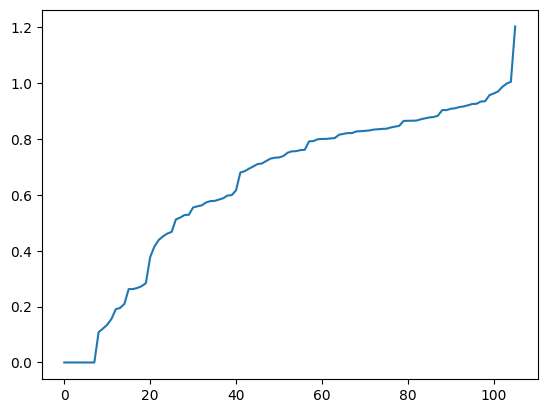

In [7]:
import matplotlib.pyplot as plt
plt.plot(np.sort(CV[1]))